In [3]:
import numpy             as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
from scipy import stats
import powerlaw

C:\Users\ldonaire\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [4]:
import pickle

def write_pkl(var,name_file):
    with open(f'variables_final\\{name_file}.pkl','wb') as arquivo:
        pickle.dump(var,arquivo)

def read_pkl(name_file):
    with open(f'variables_final\\{name_file}.pkl','rb') as arquivo:
        return pickle.load(arquivo)
    
def get_code_read_pkl(code_write_pkl):
    S = code_write_pkl.split("write_pkl(")[1]
    S = S.split("'")
    return S[0][:-1] + ' = read_pkl("' + S[1] + '")'

In [4]:
# def plot2(series, legends=0,title=None):
#     if legends==0:
#         legends = ['' for _ in series]
#     layout = go.Layout(height=1000,width=1500,title=title)
#     fig = go.Figure(data=[go.Scatter(x=series[i].index, y=series[i].values, mode='lines', name=legends[i]) for i in range(len(series))], layout=layout)
#     return fig

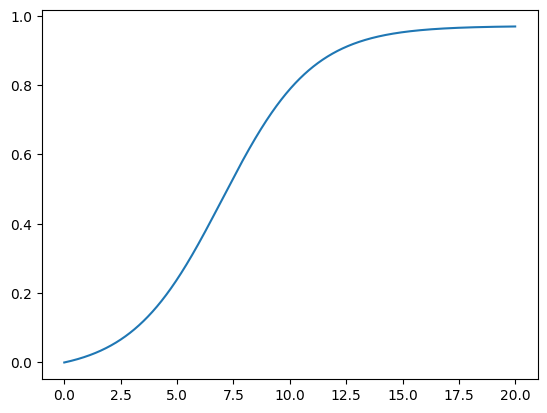

In [5]:
phi_min = 0.0 
phi_max = 1 
beta = 0.5
v_half = 7

def phi0(V, phi_min=phi_min, phi_max=phi_max, beta=beta, v_half=v_half):
    return phi_min + phi_max/(1+np.exp(-beta*(V-v_half)))

def phi(V, phi_min=phi_min, phi_max=phi_max, beta=beta, v_half=v_half):
    return phi0(V, phi_min, phi_max, beta, v_half) - phi0(0, phi_min, phi_max, beta, v_half)

x = np.arange(0,20,0.01)
y = phi(x)
plt.plot(x,y)

In [6]:
def uniform_W(k,N):
    W = k * (np.ones((N,N)) - np.eye(N))
    return W

def erdos_reny_W(k,N,p):
    W = k * np.random.binomial(1, p, size=(N, N))
    W = W - W*np.eye(N)
    return W

In [7]:
t_ref       = 0.0   # refractory period in (ms)
V_reset     = 0.0   # reset membrane potential in (mV)
def run_simulation_full(W, reset_V=True, t_sim=100, alpha=1, phi=phi, Vmax0=15, prints=False, Vmin0=0, V0=[], seed=None):
    if not pd.isnull(seed):
        np.random.seed(seed)

    #initial conditions
    phis = []
    times = []
    Vs = []

    N = len(W)
    V = np.random.uniform(Vmin0, Vmax0, size=N) 

    phi_u = np.zeros(N)    #array to store phi values
    last_spike = np.zeros(N)   # array to store last time of spike for each neuron

    # arrays to store spikes
    spk_t = [] # tempo do spike
    possible_spike_t = [] # tempo do possivel spike
    spk_id = [] # id do neuronio (0 a N-1) que teve o spike
    
    trun = 0.0 # tempo de simulacao

    times.append(trun)
    phis.append(phi_u)
    Vs.append(V)

    while (trun < t_sim):
        ALL=all(V<0.001) # sistema morre quando todos potenciais ficam abaixo de um limiar arbitrario. nesse caso, 0.001
        if ALL: 
            return np.array(spk_t), np.array(spk_id), phis, times, Vs, trun, np.array(possible_spike_t)
        
        # compute phi(T-dt)
        phi_u = phi(V)
        S = np.sum(phi_u)
        if S == 0: 
            print('S==0')
            break

        dt = np.random.exponential(scale=1/S) # jogar exponencial de taxa soma(phi)
        
        V_old = V
        V = (V)*np.exp(-alpha*dt)
        #compute V(T)
        # phi em T
        phi_u = phi(V) 

        # joga uniforme
        unif = np.random.uniform(low=0.0, high=S)
        S_new = np.sum(phi_u)
        trun += dt

        times.append(trun)
        phis.append(phi_u)
        Vs.append(V)

        possible_spike_t.append(trun)

        if unif<=S_new:
            phi_cumsum = np.cumsum(phi_u)
            neuron_id = np.where(unif<=phi_cumsum)[0][0] # acha o neuronio tal que a uniforme caiu nele

            # checking refractory period
            if last_spike[neuron_id]==0 or (trun-last_spike[neuron_id])>=t_ref:

                # updating of postsynaptic currents:
                V = V+W[neuron_id]
                last_spike[neuron_id] = trun
                # recording spike time and neuron index:
                spk_t.append(trun)
                spk_id.append(neuron_id)
                if reset_V:
                    V[neuron_id] = V_reset # Zera potencial

    return np.array(spk_t), np.array(spk_id), phis, times, Vs, trun, np.array(possible_spike_t)




def run_simulation(W, reset_V=True, t_sim=100, alpha=1, phi=phi, Vmax0=15, prints=False, Vmin0=0, V0=[], seed=None):
    if not pd.isnull(seed):
        np.random.seed(seed)

    N = len(W)
    V = np.random.uniform(Vmin0, Vmax0, size=N) 
    phi_u = np.zeros(N)    #array to store phi values
    last_spike = np.zeros(N)   # array to store last time of spike for each neuron
    trun = 0.0 # tempo de simulacao
    nspikes = 0
    while (trun < t_sim):
        ALL=all(V<0.001) # sistema morre quando todos potenciais ficam abaixo de um limiar arbitrario. nesse caso, 0.001
        if ALL: 
            return nspikes, trun

        phi_u = phi(V)
        S = np.sum(phi_u)
        if S == 0: 
            print('S==0')
            break
        
        dt = np.random.exponential(scale=1/S) # jogar exponencial de taxa soma(phi)
        V = (V)*np.exp(-alpha*dt)
        phi_u = phi(V) 
        unif = np.random.uniform(low=0.0, high=S)
        S_new = np.sum(phi_u)
        trun += dt

        if unif<=S_new:
            phi_cumsum = np.cumsum(phi_u)
            neuron_id = np.where(unif<=phi_cumsum)[0][0] # acha o neuronio tal que a uniforme caiu nele
            V = V+W[neuron_id]
            last_spike[neuron_id] = trun
            nspikes +=1
            if reset_V:
                V[neuron_id] = V_reset # Zera potencial

    return nspikes, trun

# Teste de alpha crítico

In [6]:
def fit_exp(dados):
    loc, LambdaInv = stats.expon.fit(dados)
    return 1/LambdaInv
def test_exp(dados):
    Lambda = fit_exp(dados)
    statistic, p_value = stats.kstest(dados, 'expon', args=(0, 1/Lambda))
    return p_value


def fit_norm(dados):
    return stats.norm.fit(dados)
def test_norm(dados):
    mean, std = fit_norm(dados)
    statistic, p_value = stats.kstest(dados, 'norm', args=(mean, std))
    return p_value


def fit_lognorm(dados):
    return stats.lognorm.fit(dados, floc=0)
def test_lognorm(dados):
    shape, loc, scale = fit_lognorm(dados)
    statistic, p_value = stats.kstest(dados, 'lognorm', args=(shape, loc, scale))
    return p_value


In [20]:
def fit_powerlaw(dados, discreto=False,xmin=None):
    dados = [item for item in dados if item>0]
    if pd.isnull(xmin):
        xmin = min(dados)
        # print('xmin min dados',xmin)
    fit = powerlaw.Fit(dados, xmin=xmin, discrete=discreto)
    return fit
def test_powerlaw(dados, discreto=False,xmin=None):
    fit = fit_powerlaw(dados, discreto, xmin)
    empirical_cdf = fit.cdf()
    theoretical_cdf = fit.power_law.cdf()
    ks_stat, p_value = stats.ks_2samp(empirical_cdf[1], theoretical_cdf)
    return p_value




def fit_powerlaw_fitxmin(dados, discreto=False):
    dados = [item for item in dados if item>0]
    dados = sorted(dados)
    parameter_range = {'xmin': [None, dados[len(dados)//5] ]}
    fit = powerlaw.Fit(dados,discrete=discreto, parameter_range=parameter_range)
    return fit

def test_powerlaw_fitxmin(dados, discreto=False):
    fit = fit_powerlaw_fitxmin(dados, discreto)
    empirical_cdf = fit.cdf()
    theoretical_cdf = fit.power_law.cdf()
    ks_stat, p_value = stats.ks_2samp(empirical_cdf[1], theoretical_cdf)
    return p_value

In [8]:
def plot_powerlaw(dados, discreto=False, xmin=None):
    fit = fit_powerlaw(dados, discreto, xmin)
    fig2 = fit.plot_pdf(color='b', linewidth=2)
    fig2 = fit.plot_cdf(color='r', linewidth=2)
    fig2 = fit.plot_ccdf(color='g', linewidth=2)
    fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
    fit.power_law.plot_cdf(color='r', linestyle='--', ax=fig2)
    fit.power_law.plot_ccdf(color='g', linestyle='--', ax=fig2)
    plt.title(f'xmin = {fit.xmin}, alpha = {fit.alpha}')
    plt.show()

In [8]:
np.random.seed(10)
W_U30 = uniform_W(1, 30)

W_U100 = uniform_W(1, 100)
W_ER100 = erdos_reny_W(1,100,0.7)

W_U1000 = uniform_W(1, 1000)
W_ER1000 = erdos_reny_W(1,1000,0.7)

## GL

In [9]:
def run_gl(W, alpha, n_simulations=300):
    times_death = []
    num_spikes = []
    for i in range(n_simulations):
        # spk_t, spk_id, phis, times, Vs, trun, possible_spike_t = run_simulation(W, True, np.inf, alpha)
        # num_spikes.append(len(spk_id))
        nspikes, trun = run_simulation(W, True, np.inf, alpha)
        num_spikes.append(nspikes)
        times_death.append(trun)
    return times_death, num_spikes

def find_alpha_critical_gl(W, string_W, alpha0, step, max_tests=20, plot=True):
    alpha = alpha0
    results = {}
    for i in range(max_tests):
        durations,sizes = run_gl(W, alpha, 300)
        results[alpha] = [durations,sizes]
        if plot:
            plt.hist(np.array(durations)/np.mean(durations), bins=[item/5 for item in range(15*10)], density=True)
            plt.title(f'GL | {string_W} | alpha={np.round(alpha,2)} | pvalue={np.round(test_exp(durations),4)}')
            plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
            plt.show()
        if test_exp(durations) > 0.05:
            print('critical alpha')
            print(alpha)
            return alpha, durations, sizes, results
        alpha = np.round(alpha-step,2)
    print('No critical alpha found')
    return alpha, durations, sizes, results


def find_alpha_critical_gl_append(results, W, string_W, alpha0, step, max_tests=20, plot=True):
    alpha = alpha0
    # results = {}
    for i in range(max_tests):
        print()
        print('alpha', alpha)
        if alpha in results.keys():
            print(alpha,' in dicio')
            alpha = np.round(alpha-step,2)
            continue
        durations,sizes = run_gl(W, alpha, 300)
        results[alpha] = [durations,sizes]
        if plot:
            plt.hist(np.array(durations)/np.mean(durations), bins=[item/5 for item in range(15*10)], density=True)
            plt.title(f'GL | {string_W} | alpha={np.round(alpha,2)} | pvalue={np.round(test_exp(durations),4)}')
            plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
            plt.show()
        if test_exp(durations) > 0.05:
            print('critical alpha')
            print(alpha)
            # return alpha, durations, sizes, results
        alpha = np.round(alpha-step,2)
    print('No critical alpha found')
    results = dict(sorted(results.items(),reverse=True))
    return alpha, durations, sizes, results



### GL U 100

In [10]:
results_U100 = read_pkl('alpha_critical\\GL_U100')

In [11]:
results_U100.keys()

dict_keys([np.float64(6.1), np.float64(6.0), np.float64(5.9), np.float64(5.8), np.float64(5.7), np.float64(5.6), np.float64(5.5), np.float64(5.4), np.float64(5.3), np.float64(5.2), np.float64(5.1), np.float64(5.0), np.float64(4.9), np.float64(4.8), np.float64(4.7), 4.6])

In [ ]:
# alpha_U100, durations_U100, sizes_U100, results_U100 = find_alpha_critical_gl(W_U100, 5.2, 0.1, 8)
# alpha_U100, durations_U100, sizes_U100, results_U100 = find_alpha_critical_gl_append(results_U100, W_U100, 'W=Unif 100',5.2, -0.1, 10)
alpha_U100, durations_U100, sizes_U100, results_U100 = find_alpha_critical_gl_append(results_U100, W_U100, 'W=Unif 100',4.6, 0.2, 3)
write_pkl(results_U100,'alpha_critical\\GL_U100')

# print(test_exp(durations_U100))
# plt.hist(np.array(durations_U100)/np.mean(durations_U100), bins=[item/5 for item in range(15*10)], density=True)
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
# plt.show()


alpha 4.6
4.6  in dicio

alpha 4.4


In [ ]:
del [alpha_U100, durations_U100, sizes_U100, results_U100]

### GL U 1000

In [ ]:
results_U1000 = read_pkl('alpha_critical\\GL_U1000')

In [ ]:
results_U1000.keys()

dict_keys([np.int64(71), np.int64(69), np.int64(67), np.int64(65), np.int64(63), np.int64(61), np.int64(59), np.int64(57), np.int64(55), 53, np.int64(52), np.int64(51), np.int64(50), np.int64(49)])

In [ ]:
# alpha_U1000, durations_U1000, sizes_U1000, results_U1000 = find_alpha_critical_gl(W_U1000, 52, 1, 10)
# alpha_U1000, durations_U1000, sizes_U1000, results_U1000 = find_alpha_critical_gl_append(results_U1000, W_U1000, 'W=Unif 1000',53, -2, 10)
alpha_U1000, durations_U1000, sizes_U1000, results_U1000 = find_alpha_critical_gl_append(results_U1000, W_U1000, 'W=Unif 1000',48, 2, 3)
write_pkl(results_U1000,'alpha_critical\\GL_U1000')
# print(results_U1000.keys())
# print(test_exp(durations_U1000))
# plt.hist(np.array(durations_U1000)/np.mean(durations_U1000), bins=[item/5 for item in range(15*10)], density=True)
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
# plt.show()


alpha 48


In [ ]:
del [alpha_U1000, durations_U1000, sizes_U1000, results_U1000]

### Random

In [ ]:
# def round_keys(dicio):
#     dicio_copy = {}
#     for key,value in dicio.items():
#         dicio_copy[np.round(key,2)] = value
#     return dicio_copy

# results_U1000 = round_keys(results_U1000)
# results_U100 = round_keys(results_U100)
# resultsHK_U100 = round_keys(resultsHK_U100)

In [ ]:
# alpha_U30, durations_U30, sizes_U30, results_U30 = find_alpha_critical_gl(W_U30,'W=Unif 30', 1.3, 0.1, 4)
# write_pkl(results_U30,'alpha_critical\\GL_U30')
# print(test_exp(durations_U30))
# plt.hist(np.array(durations_U30)/np.mean(durations_U30), bins=[item/5 for item in range(15*10)], density=True)
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
# plt.show()

In [40]:
# durations_U30, sizes_U30 = run_gl(W_U30, 1)
# print(test_exp(durations_U30))
# plt.hist(np.array(durations_U30)/np.mean(durations_U30), bins=[item/5 for item in range(15*10)], density=True)
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
# plt.show()

In [ ]:
# durations_U100, sizes_U100 = run_gl(W_U100, 4.8)
# print(test_exp(durations_U100))
# plt.hist(np.array(durations_U100)/np.mean(durations_U100), bins=[item/5 for item in range(15*10)], density=True)
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
# plt.show()

In [ ]:
# durations_ER100, sizes_ER100 = run_gl(W_ER100, 3.3)
# print(test_exp(durations_ER100))
# plt.hist(np.array(durations_ER100)/np.mean(durations_ER100), bins=[item/5 for item in range(15*10)], density=True)
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
# plt.show()

In [ ]:
# durations_U1000, sizes_U1000 = run_gl(W_U1000, 50)
# print(test_exp(durations_U1000))
# plt.hist(np.array(durations_U1000)/np.mean(durations_U1000), bins=[item/5 for item in range(15*10)], density=True)
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
# plt.show()

In [ ]:
# durations_ER1000, sizes_ER1000 = run_gl(W_ER1000, 40)
# print(test_exp(durations_ER1000))
# plt.hist(np.array(durations_ER1000)/np.mean(durations_ER1000), bins=[item/5 for item in range(15*10)], density=True)
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
# plt.show()

## Hawkes

In [ ]:
def run_hk(W, alpha, n_simulations=300):
    times_death = []
    num_spikes = []
    for i in range(n_simulations):
        # spk_t, spk_id, phis, times, Vs, trun, possible_spike_t = run_simulation(W, False, np.inf, alpha)
        nspikes, trun = run_simulation(W, False, np.inf, alpha)
        times_death.append(trun)
        num_spikes.append(nspikes)
    return times_death, num_spikes

def find_alpha_critical_hk(W, string_W, alpha0, step, max_tests=20, plot=True):
    alpha = alpha0
    results = {}
    for i in range(max_tests):
        durations,sizes = run_hk(W, alpha, 300)
        results[alpha] = [durations,sizes]
        if plot:
            plt.hist(np.array(durations)/np.mean(durations), bins=[item/5 for item in range(15*10)], density=True)
            plt.title(f'Hawkes | {string_W} | alpha={np.round(alpha,2)} | pvalue={np.round(test_exp(durations),4)}')
            plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
            plt.show()
        if test_exp(durations) > 0.05:
            print('critical alpha')
            print(alpha)
            return alpha, durations, sizes, results
        alpha = np.round(alpha-step,2)
    print('No critical alpha found')
    return alpha, durations, sizes, results

def find_alpha_critical_hk_append(results, W, string_W, alpha0, step, max_tests=20, plot=True):
    alpha = alpha0
    # results = {}
    for i in range(max_tests):
        print()
        print(f'alpha = {alpha}')
        if alpha in results.keys():
            print(alpha, 'in dicio')
            alpha = np.round(alpha-step,2)
            continue
        durations,sizes = run_hk(W, alpha, 300)
        results[alpha] = [durations,sizes]
        if plot:
            plt.hist(np.array(durations)/np.mean(durations), bins=[item/5 for item in range(15*10)], density=True)
            plt.title(f'Hawkes | {string_W} | alpha={np.round(alpha,2)} | pvalue={np.round(test_exp(durations),4)}')
            plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
            plt.show()
        if test_exp(durations) > 0.05:
            print('critical alpha')
            print(alpha)
            return alpha, durations, sizes, results
        alpha = np.round(alpha-step,2)
    print('No critical alpha found')
    results = dict(sorted(results.items(),reverse=True))
    return alpha, durations, sizes, results


        

### HK U 100

In [ ]:
resultsHK_U100 = read_pkl('alpha_critical\\HK_U100')

In [ ]:
resultsHK_U100.keys()

dict_keys([7, 6.8, 6.6, 6.3999999999999995, 6.199999999999999, 5.999999999999999, 5.799999999999999, 5.599999999999999, 5.399999999999999, 5.199999999999998, 4.999999999999998, 4.799999999999998])

In [ ]:
# alphaHK_U100, durationsHK_U100, sizesHK_U100, resultsHK_U100 = find_alpha_critical_hk(W_U100,'W=Unif 100', 7, 0.2, 12)
alphaHK_U100, durationsHK_U100, sizesHK_U100, resultsHK_U100 = find_alpha_critical_hk_append(resultsHK_U100,W_U100,'W=Unif 100', 7, -0.2, 10)
write_pkl(resultsHK_U100,'alpha_critical\\HK_U100')

In [ ]:
alphaHK_U100, durationsHK_U100, sizesHK_U100, resultsHK_U100 = find_alpha_critical_hk_append(resultsHK_U100,W_U100,'W=Unif 100', 4.6, 0.2, 3)
write_pkl(resultsHK_U100,'alpha_critical\\HK_U100')

# print(test_exp(durations_U100))
# plt.hist(np.array(durations_U100)/np.mean(durations_U100), bins=[item/5 for item in range(15*10)], density=True)
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
# plt.show()

In [ ]:
del [alphaHK_U100, durationsHK_U100, sizesHK_U100, resultsHK_U100]

### HK U 100

In [ ]:
alphaHK_U1000, durationsHK_U1000, sizesHK_U1000, resultsHK_U1000 = find_alpha_critical_hk(W_U1000,'W=Unif 1000', 80, 5, 8)
write_pkl(resultsHK_U1000,'alpha_critical\\HK_U1000')

# print(test_exp(durations_U1000))
# plt.hist(np.array(durations_U1000)/np.mean(durations_U1000), bins=[item/5 for item in range(15*10)], density=True)
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
# plt.show()

## Random - Testes PL

In [206]:
# alphaHK_U30, durationsHK_U30, sizesHK_U30, resultsHK_U30 = find_alpha_critical_hk(W_U30,'W=Unif 30', 2, 0.1, 10)
# write_pkl(resultsHK_U30,'alpha_critical\\HK_U30')
# print(test_exp(durations_U30))
# plt.hist(np.array(durations_U30)/np.mean(durations_U30), bins=[item/5 for item in range(15*10)], density=True)
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
# plt.show()

In [307]:
# dur,sizes = run_gl(W_U100, 8)
# print(test_exp(dur))
# print(test_lognorm(dur))
# print(test_powerlaw(dur))
# print(test_norm(dur))
# plt.hist(np.array(dur)/np.mean(dur), bins=[item/5 for item in range(15*10)], density=True)
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
# plt.show()

# print('min', min([item for item in sizes if item>0]))
# # plot_powerlaw([item for item in sizes if item>0], discreto=True)
# # plot_powerlaw([item+1 for item in sizes if item>0], discreto=True)
# # plot_powerlaw(sizes, discreto=True)
# # plot_powerlaw(sizes, discreto=True, xmin=1)
# # plot_powerlaw(dur)


In [ ]:
def fit_exp(dados):
    loc, LambdaInv = stats.expon.fit(dados)
    return 1/LambdaInv
def test_exp(dados):
    Lambda = fit_exp(dados)
    statistic, p_value = stats.kstest(dados, 'expon', args=(0, 1/Lambda))
    return p_value

In [222]:
test_exp(data)

np.float64(0.07135961590229978)

In [226]:
ks_stat, p_value = stats.kstest(data, 'powerlaw', args=(0, scale))
p_value

np.float64(nan)

In [235]:

# data = results_U1000[49][0]
# data = resultsHK_U100[7][0]
# shape,loc,scale = stats.pareto.fit(data)
# print(stats.kstest(data,'pareto',args=(shape,loc,scale)).pvalue)


# for keyy in resultsHK_U100.keys():
    # data = resultsHK_U100[keyy][0]
    # print(stats.kstest(data,'pareto',args=stats.pareto.fit(data)).pvalue)

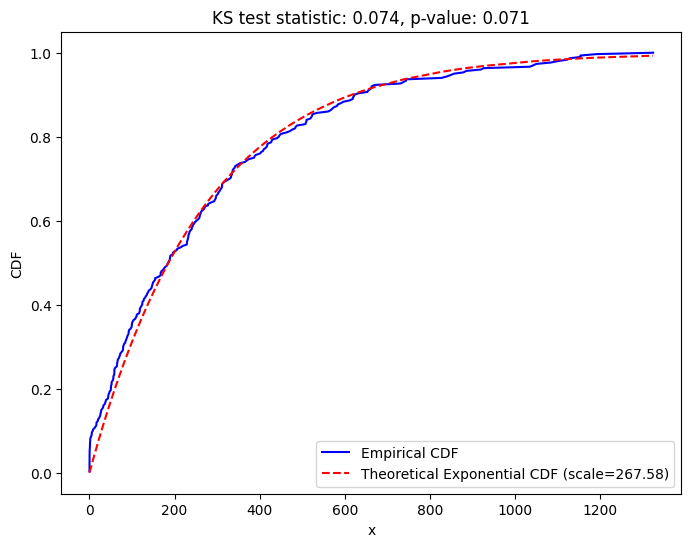

Estimated scale (1/lambda): 267.57652811623234
KS Statistic: 0.07396160690108299, p-value: 0.07135961590229978


In [224]:
data = results_U1000[49][0]

loc, scale = stats.expon.fit(data)  # Estima o parâmetro de escala
# loc = 0
# Calcular a CDF empírica dos dados
data_sorted = np.sort(data)
empirical_cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)

# Calcular a CDF teórica da distribuição exponencial ajustada
exponential_cdf = stats.expon.cdf(data_sorted, loc=loc, scale=scale)

# Fazer o teste KS entre a CDF empírica e a CDF teórica da exponencial ajustada
# ks_stat, p_value = stats.ks_2samp(empirical_cdf, exponential_cdf)
ks_stat, p_value = stats.kstest(data, 'expon', args=(0, scale))

# Plot da CDF empírica e da CDF da exponencial ajustada
plt.figure(figsize=(8, 6))
plt.plot(data_sorted, empirical_cdf, label='Empirical CDF', color='blue')
plt.plot(data_sorted, exponential_cdf, linestyle='--', label=f'Theoretical Exponential CDF (scale={scale:.2f})', color='red')
plt.xlabel('x')
plt.ylabel('CDF')
plt.legend()
plt.title(f'KS test statistic: {ks_stat:.3f}, p-value: {p_value:.3f}')
plt.show()

print(f"Estimated scale (1/lambda): {scale}")
print(f"KS Statistic: {ks_stat}, p-value: {p_value}")

In [66]:
resultsHK_U100.keys()

dict_keys([7, 6.8, 6.6, 6.3999999999999995, 6.199999999999999, 5.999999999999999, 5.799999999999999, 5.599999999999999, 5.399999999999999, 5.199999999999998, 4.999999999999998, 4.799999999999998])

In [65]:
test_lognorm(resultsHK_U100[6.3999999999999995][0])

np.float64(0.18091835427234826)

Calculating best minimal value for power law fit
xmin progress: 99%
7
logn 2.8892295930504644e-06
PL x EXP
(np.float64(286.53975665867233), np.float64(5.556791401342328e-16))
PL x LogN
(np.float64(-3.8656887490634464), np.float64(0.05281402135199878))
LogN x EXP
(np.float64(290.4054454077356), np.float64(9.235730429547665e-18))


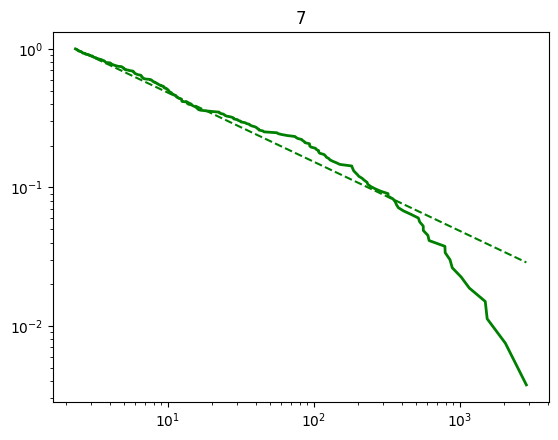

Calculating best minimal value for power law fit
xmin progress: 99%
6.8
logn 0.0017920483164242675
PL x EXP
(np.float64(155.17787378558498), np.float64(2.5336844992848783e-08))
PL x LogN
(np.float64(-5.207902051464589), np.float64(0.03522908615505691))
LogN x EXP
(np.float64(160.38577583704964), np.float64(5.733117422266074e-10))


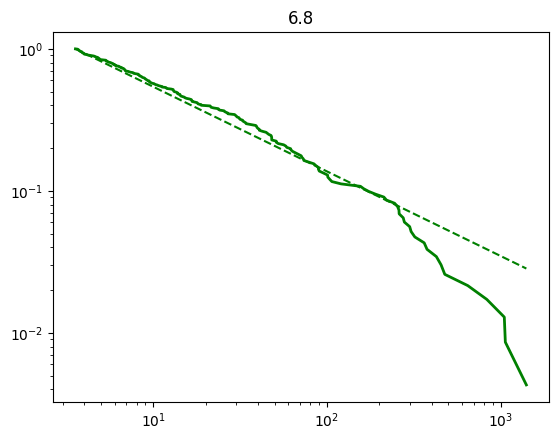

Calculating best minimal value for power law fit
xmin progress: 99%
6.6
logn 0.0003809200716210093
PL x EXP
(np.float64(149.63390220905822), np.float64(2.1630590667117655e-09))
PL x LogN
(np.float64(-5.272721641598734), np.float64(0.027827284842020388))
LogN x EXP
(np.float64(154.90662385065707), np.float64(1.664204703310873e-11))


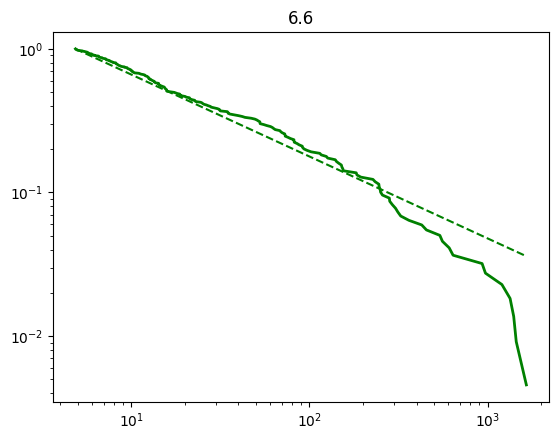

Calculating best minimal value for power law fit
xmin progress: 99%
6.3999999999999995
logn 0.18091835427234826
PL x EXP
(np.float64(42.40434787074078), np.float64(0.002726442244157416))
PL x LogN
(np.float64(-6.083588967988155), np.float64(0.02379685113042105))
LogN x EXP
(np.float64(48.487936838728906), np.float64(3.9246170373474616e-05))


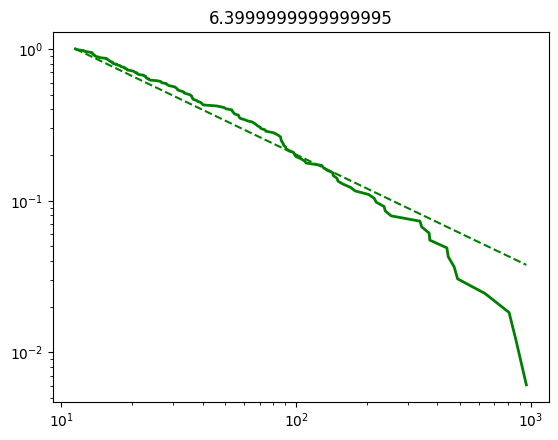

Calculating best minimal value for power law fit
xmin progress: 99%
6.199999999999999
logn 0.039642209318444976
PL x EXP
(np.float64(81.51543714921067), np.float64(3.81509183438788e-07))
PL x LogN
(np.float64(-3.715387326888946), np.float64(0.05910838279379004))
LogN x EXP
(np.float64(85.23082447609966), np.float64(2.679967592417514e-09))


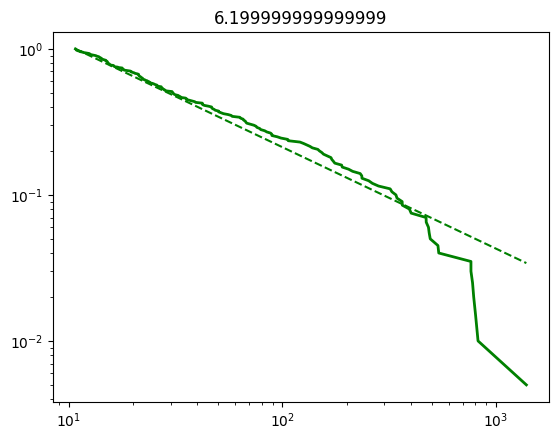

Calculating best minimal value for power law fit
xmin progress: 99%
5.999999999999999
logn 0.26962822046393986
PL x EXP
(np.float64(68.7280021428738), np.float64(0.016528267660636253))
PL x LogN
(np.float64(-48.26282214830129), np.float64(2.6037784853504918e-09))
LogN x EXP
(np.float64(116.99082429117509), np.float64(1.4237116091068342e-07))


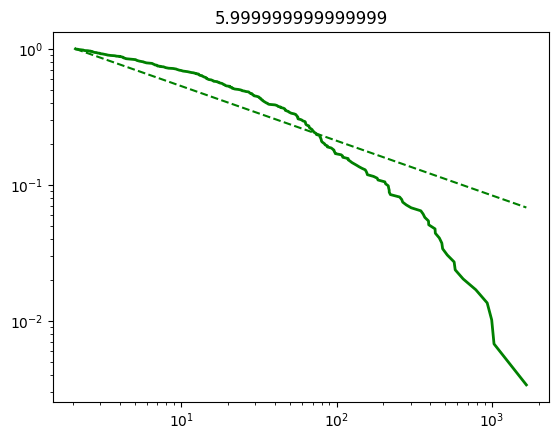

Calculating best minimal value for power law fit
xmin progress: 99%
5.799999999999999
logn 0.326664725305146
PL x EXP
(np.float64(-10.893245123852846), np.float64(0.28569328810685746))
PL x LogN
(np.float64(-26.84833505747718), np.float64(1.9625553571013236e-06))
LogN x EXP
(np.float64(15.955089933624269), np.float64(0.0014782402601265236))


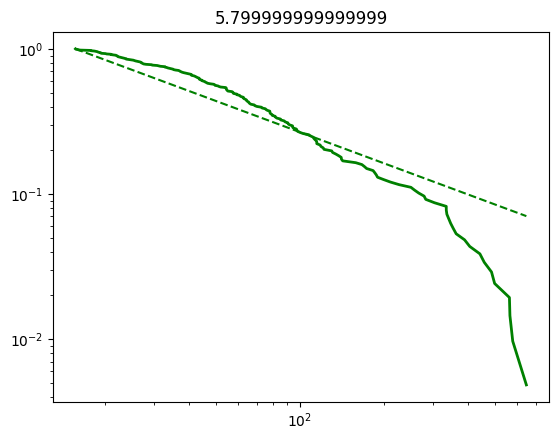

Calculating best minimal value for power law fit
xmin progress: 99%
5.599999999999999
logn 0.04698246299902176
PL x EXP
(np.float64(-2.5985205759466066), np.float64(0.7669872810372919))
PL x LogN
(np.float64(-13.12831282148363), np.float64(0.001325476320672544))
LogN x EXP
(np.float64(10.529792245537028), np.float64(0.03630971239409877))


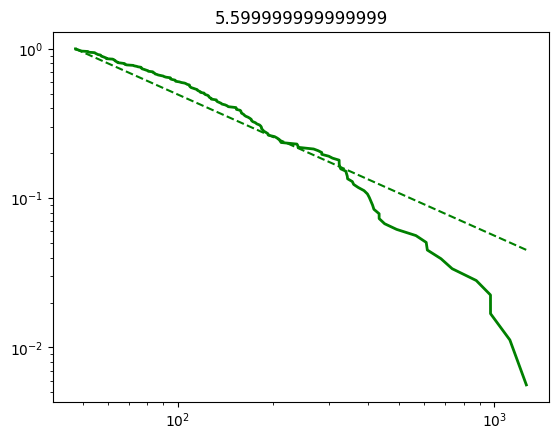

Calculating best minimal value for power law fit
xmin progress: 99%
5.399999999999999
logn 0.001730552418909691
PL x EXP
(np.float64(-21.094267048556393), np.float64(0.00027991422771985055))
PL x LogN
(np.float64(-19.2712356614123), np.float64(0.00019958958423308443))
LogN x EXP
(np.float64(-1.8230313871440895), np.float64(0.10881864629236031))


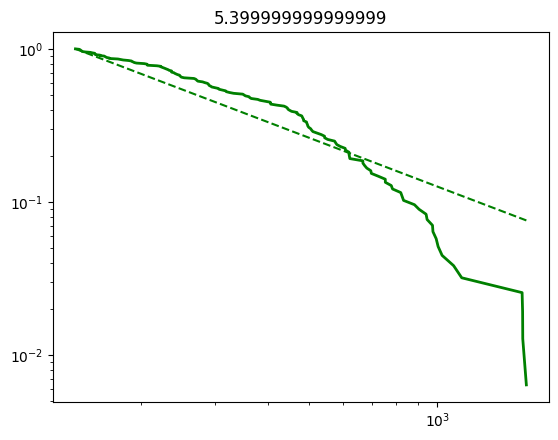

Calculating best minimal value for power law fit
xmin progress: 99%
5.199999999999998
logn 4.219350169160066e-06
PL x EXP
(np.float64(1.0667579549887343), np.float64(0.6980003277898825))
PL x LogN
(np.float64(-0.3839346576156082), np.float64(0.6171511182729383))
LogN x EXP
(np.float64(1.4506926126043425), np.float64(0.4704155990457721))


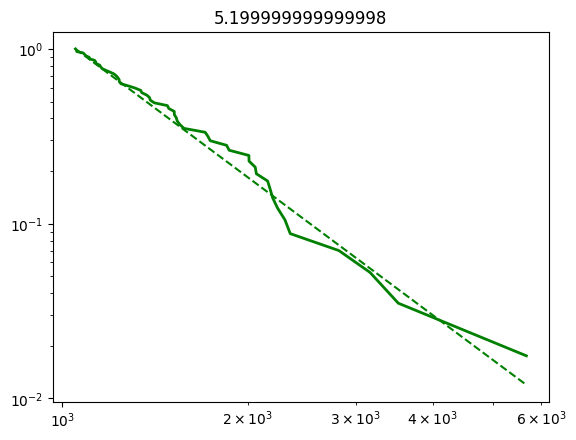

Calculating best minimal value for power law fit
xmin progress: 99%
4.999999999999998
logn 4.750240503141537e-09
PL x EXP
(np.float64(-14.258999307919087), np.float64(0.00022447608493015843))
PL x LogN
(np.float64(-12.360183858706874), np.float64(0.0015721627288784164))
LogN x EXP
(np.float64(-1.8988154492122122), np.float64(0.0006870121302510915))


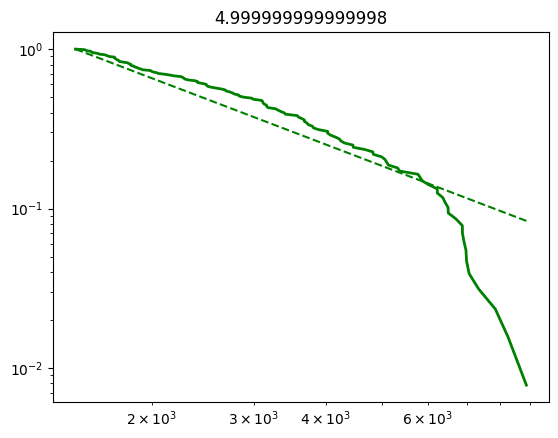

Calculating best minimal value for power law fit
xmin progress: 99%
4.799999999999998
logn 5.570888714746988e-08
PL x EXP
(np.float64(1.1759762442786954), np.float64(0.5530377453441191))
PL x LogN
(np.float64(-0.1104287987808501), np.float64(0.7630976691215682))
LogN x EXP
(np.float64(1.2864050430595455), np.float64(0.42927608954965957))


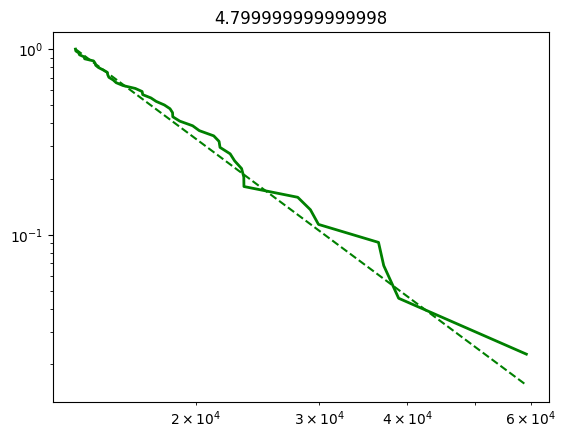

In [308]:
# data_exponencial = resultsHK_U100[4.799999999999998][0]
# data_exponencial = resultsHK_U100[4.999999999999998][0]
# data_exponencial = resultsHK_U100[5.399999999999999][0]
# data_exponencial = resultsHK_U100[6.3999999999999995][0]
# data_exponencial = resultsHK_U100[6.6][0]

for key in resultsHK_U100.keys():
    data_exponencial = resultsHK_U100[key][0]

    parameter_range = {'xmin': [None, data_exponencial[2*len(data_exponencial)//3] ]}
    # parameter_range = {}

    fit = powerlaw.Fit(data_exponencial,parameter_range=parameter_range)
    print()
    print(key)
    print('logn', test_lognorm(data_exponencial))
    print('PL x EXP')
    print(fit.distribution_compare('power_law','exponential'))
    print('PL x LogN')
    print(fit.distribution_compare('power_law','lognormal'))
    print('LogN x EXP')
    print(fit.distribution_compare('lognormal','exponential'))

    # fig2 = fit.plot_pdf(color='b', linewidth=2)
    # fig2 = fit.plot_cdf(color='r', linewidth=2)
    fig2 = fit.plot_ccdf(color='g', linewidth=2)
    # fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
    # fit.power_law.plot_cdf(color='r', linestyle='--', ax=fig2)
    fit.power_law.plot_ccdf(color='g', linestyle='--', ax=fig2)
    plt.title(key)
    plt.show()

In [120]:
# fit = powerlaw.Fit(data_exponencial,parameter_range=parameter_range)
stats.kstest(data_exponencial,fit.cdf()[0])

KstestResult(statistic=np.float64(0.8533333333333334), pvalue=np.float64(1.2629110735032043e-30), statistic_location=np.float64(13160.878598985422), statistic_sign=np.int8(1))

In [132]:
theoretical_cdf

array([0.        , 0.00122177, 0.003211  , 0.01064567, 0.01400804,
       0.01660523, 0.03144521, 0.04953311, 0.05404663, 0.06560333,
       0.07123324, 0.08121383, 0.08384772, 0.08436237, 0.09141309,
       0.09551998, 0.09883905, 0.11209627, 0.11338573, 0.11604184,
       0.12308767, 0.12922683, 0.1294528 , 0.14561675, 0.1567921 ,
       0.15739481, 0.15844703, 0.16180146, 0.16609007, 0.17821366,
       0.17950335, 0.18415465, 0.19887937, 0.19977189, 0.20261646,
       0.20331843, 0.21271793, 0.21940592, 0.2204283 , 0.22676797,
       0.22970799, 0.23607376, 0.24112053, 0.24231501, 0.2571591 ,
       0.25813583, 0.25855192, 0.26134551, 0.2660077 , 0.26784642,
       0.27092471, 0.27313167, 0.28057008, 0.28252532, 0.28968849,
       0.30357516, 0.303761  , 0.31681002, 0.31750232, 0.31917066,
       0.32311453, 0.32977812, 0.33130013, 0.33670094, 0.33714413,
       0.33960766, 0.34016079, 0.34550729, 0.34608409, 0.34921622,
       0.35412523, 0.37368929, 0.37864027, 0.38351121, 0.39387

In [147]:
fit.power_law.cdf().__len__()


219

In [148]:
empirical_cdf[1].__len__()

300

In [152]:
list(resultsHK_U100.keys())[0]

7

In [193]:
fit.supported_distributions

{'power_law': powerlaw.Power_Law,
 'lognormal': powerlaw.Lognormal,
 'exponential': powerlaw.Exponential,
 'truncated_power_law': powerlaw.Truncated_Power_Law,
 'stretched_exponential': powerlaw.Stretched_Exponential,
 'lognormal_positive': powerlaw.Lognormal_Positive}

In [205]:
# fit = powerlaw.Stretched_Exponential(xmin=min(data_exponencial)).fit(data_exponencial)
# fit.plot_pdf(color='b', linewidth=2)
# data_exponencial

In [60]:
# def fit_powerlaw(dados, discreto=False):
#     fit = powerlaw.Fit(dados, xmin=min(dados),discrete=discreto)
#     return fit

# def test_powerlaw(dados, discreto=False):
#     fit = fit_powerlaw(dados, discreto)
#     empirical_cdf = fit.cdf()
#     theoretical_cdf = fit.power_law.cdf()
#     ks_stat, p_value = stats.ks_2samp(empirical_cdf[1], theoretical_cdf)
#     return p_value



# def fit_powerlaw_fitxmin(dados, discreto=False):
#     parameter_range = {'xmin': [None, dados[len(dados)//2] ]}
#     fit = powerlaw.Fit(dados,discrete=discreto)
#     return fit

# def test_powerlaw_fitxmin(dados, discreto=False):
#     fit = fit_powerlaw_fitxmin(dados, discreto)
#     empirical_cdf = fit.cdf()
#     theoretical_cdf = fit.power_law.cdf()
#     ks_stat, p_value = stats.ks_2samp(empirical_cdf[1], theoretical_cdf)
#     return p_value

In [312]:
# keyy = list(resultsHK_U100.keys())[0]
# for _ in range(1):

for keyy in list(resultsHK_U100.keys()):


    # data_exponencial = resultsHK_U100[keyy][0]
    data_exponencial = [item for item in resultsHK_U100[keyy][1] if item>0]

    # parameter_range = {'xmin': [None, data_exponencial[len(data_exponencial)//2] ]}
    # fit = powerlaw.Fit(data_exponencial,parameter_range=parameter_range)

    # fit = powerlaw.Fit(data_exponencial)

    print('-----------------')
    print(keyy)
    # fit = powerlaw.Fit(data_exponencial, xmin=min(data_exponencial))

    # alpha = fit.power_law.alpha
    # xmin = fit.power_law.xmin

    # empirical_cdf = fit.cdf()
    # theoretical_cdf = fit.power_law.cdf()

    # ks_stat, p_value = stats.ks_2samp(empirical_cdf[1], theoretical_cdf)

    # p_value = test_powerlaw(data_exponencial)
    p_value = test_powerlaw(data_exponencial, True)
    # fig2 = fit.plot_pdf(color='b', linewidth=2)
    # fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
    # fit.plot_ccdf(color='r', linewidth=2, ax=fig2)
    # fit.power_law.plot_ccdf(color='r', linestyle='--', ax=fig2)
    # fit.plot_cdf(color='g', linewidth=2, ax=fig2)
    # fit.power_law.plot_cdf(color='g', linestyle='--', ax=fig2)
    # plt.show()

    # print(f"Estimated alpha: {alpha}")
    print(f"POWELAW --- p-value: {p_value}, PL = {p_value>0.05}")
    # print(len(theoretical_cdf))
    pvlognorm = test_lognorm(data_exponencial)
    print(f"LOGNORM --- p-value: {pvlognorm}, PL = {pvlognorm>0.05}")
    pvexp = test_exp(data_exponencial)
    print(f"EXP --- p-value: {pvexp}, PL = {pvexp>0.05}")
    print()

-----------------
7
xmin min dados 1
POWELAW --- p-value: 8.37252829535952e-12, PL = False
LOGNORM --- p-value: 0.001134638370395961, PL = False
EXP --- p-value: 8.416309409142948e-32, PL = False

-----------------
6.8
xmin min dados 1
POWELAW --- p-value: 1.0051001172122527e-10, PL = False
LOGNORM --- p-value: 0.00017500846473652315, PL = False
EXP --- p-value: 4.651579686742606e-44, PL = False

-----------------
6.6
xmin min dados 1
POWELAW --- p-value: 1.8661636795549284e-08, PL = False
LOGNORM --- p-value: 0.0004143833589996189, PL = False
EXP --- p-value: 4.8823152550027254e-45, PL = False

-----------------
6.3999999999999995
xmin min dados 1
POWELAW --- p-value: 2.4758068018403678e-08, PL = False
LOGNORM --- p-value: 0.00083689610666876, PL = False
EXP --- p-value: 1.0742553207616848e-42, PL = False

-----------------
6.199999999999999
xmin min dados 1
POWELAW --- p-value: 4.596750956612726e-08, PL = False
LOGNORM --- p-value: 7.378075473753195e-06, PL = False
EXP --- p-value: 5

In [197]:
fit.distribution_compare('power_law','stretched_exponential')

(np.float64(-10.959291171812604), np.float64(0.0007151469922228298))

# OFC - Teste de distribuicoes

In [ ]:
raise Exception('Prog exp e lognorm com xmin fodase.....')

In [12]:
def test_sizes(results, plot=False):
    for keyy in list(results.keys()):
        print()
        print(keyy)
        sizes = [item for item in results[keyy][1] if item>0]
        p_value = test_powerlaw(sizes, True)
        print(f"POWELAW --- p-value: {p_value}, PL = {p_value>0.05}")
        p_value2 = test_powerlaw_fitxmin(sizes, True)
        print(f"POWELAW --- p-value: {p_value2}, PL_F = {p_value2>0.05}")
        pvlognorm = test_lognorm(sizes)
        print(f"LOGNORM --- p-value: {pvlognorm}, LN = {pvlognorm>0.05}")
        pvexp = test_exp(sizes)
        print(f"EXP --- p-value: {pvexp}, EXP = {pvexp>0.05}")

        if plot:
            fit = fit_powerlaw(sizes,True)
            # fig2 = fit.plot_pdf(color='b', linewidth=2)
            # fig2 = fit.plot_cdf(color='r', linewidth=2)
            # fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
            # fit.power_law.plot_cdf(color='r', linestyle='--', ax=fig2)
            fig2 = fit.plot_ccdf(color='b', linewidth=2)
            fit.power_law.plot_ccdf(color='black', linestyle='--', ax=fig2)
            plt.title(f'alpha = {keyy} | expoent = {fit.alpha}')
            plt.show()

            fit = fit_powerlaw_fitxmin(sizes,True)
            fig2 = fit.plot_ccdf(color='r', linewidth=2)
            fit.power_law.plot_ccdf(color='black', linestyle='--', ax=fig2)
            plt.title(f'FIT XMIN | alpha = {keyy} | expoent = {fit.alpha} | xmin = {fit.xmin}')
            plt.show()

            plt.hist(np.array(sizes)/np.mean(sizes), bins=[item/5 for item in range(15*10)], density=True)
            plt.title(f'alpha = {keyy}')
            plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
            plt.show()

def test_durations(results, plot=False):
    for keyy in list(results.keys()):
        print()
        print(keyy)
        durations = results[keyy][0]
        p_value = test_powerlaw(durations, False)
        print(f"POWELAW --- p-value: {p_value}, PL = {p_value>0.05}")
        p_value2 = test_powerlaw_fitxmin(durations, False)
        print(f"POWELAW --- p-value: {p_value2}, PL_F = {p_value2>0.05}")
        pvlognorm = test_lognorm(durations)
        print(f"LOGNORM --- p-value: {pvlognorm}, PL = {pvlognorm>0.05}")
        pvexp = test_exp(durations)
        print(f"EXP --- p-value: {pvexp}, PL = {pvexp>0.05}")
        if plot:
            fit = fit_powerlaw(durations,False)
            # fig2 = fit.plot_pdf(color='b', linewidth=2)
            # fig2 = fit.plot_cdf(color='r', linewidth=2)
            # fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
            # fit.power_law.plot_cdf(color='r', linestyle='--', ax=fig2)
            fig2 = fit.plot_ccdf(color='b', linewidth=2)
            fit.power_law.plot_ccdf(color='black', linestyle='--', ax=fig2)
            plt.title(f'alpha = {keyy} | expoent = {fit.alpha}')
            plt.show()

            fit = fit_powerlaw_fitxmin(durations,False)
            fig2 = fit.plot_ccdf(color='r', linewidth=2)
            fit.power_law.plot_ccdf(color='black', linestyle='--', ax=fig2)
            plt.title(f'FIT XMIN | alpha = {keyy} | expoent = {fit.alpha} | xmin = {fit.xmin}')
            plt.show()

            plt.hist(np.array(durations)/np.mean(durations), bins=[item/5 for item in range(15*10)], density=True)
            plt.title(f'alpha = {keyy}')
            plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
            plt.show()


71
POWELAW --- p-value: 0.21005749381264038, PL = True
Calculating best minimal value for power law fit
POWELAW --- p-value: 0.6715955632559698, PL_F = True
LOGNORM --- p-value: 0.00013540707080937614, PL = False
EXP --- p-value: 1.9146566366187795e-61, PL = False


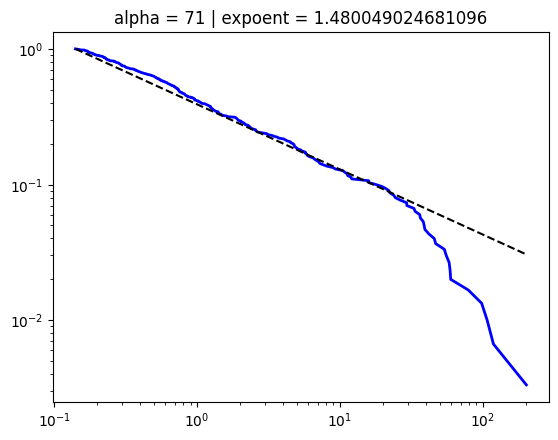

Calculating best minimal value for power law fit


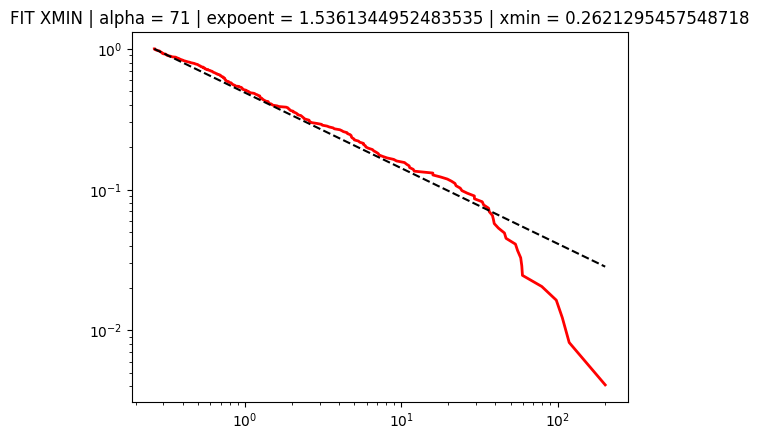

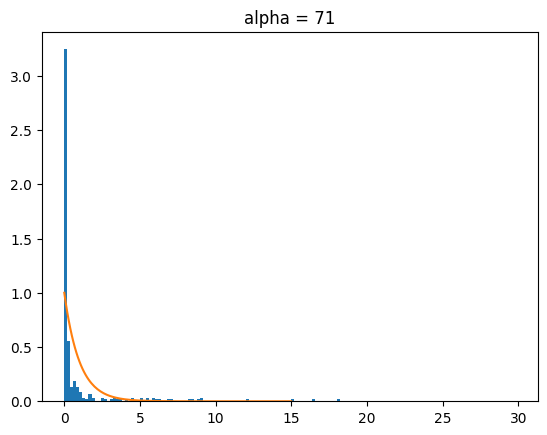


69
POWELAW --- p-value: 0.12122695053622792, PL = True
Calculating best minimal value for power law fit
POWELAW --- p-value: 0.3210975047024049, PL_F = True
LOGNORM --- p-value: 0.0007763684625810088, PL = False
EXP --- p-value: 2.3731999880153747e-56, PL = False


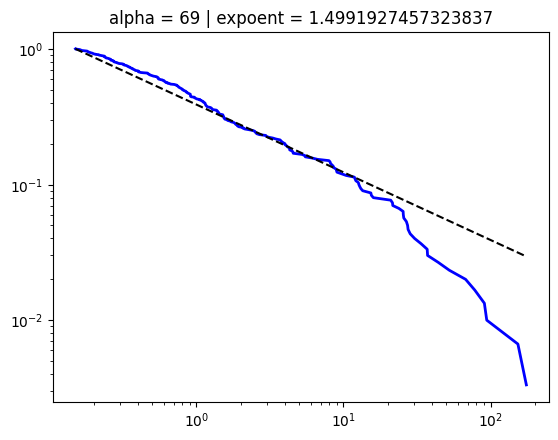

Calculating best minimal value for power law fit


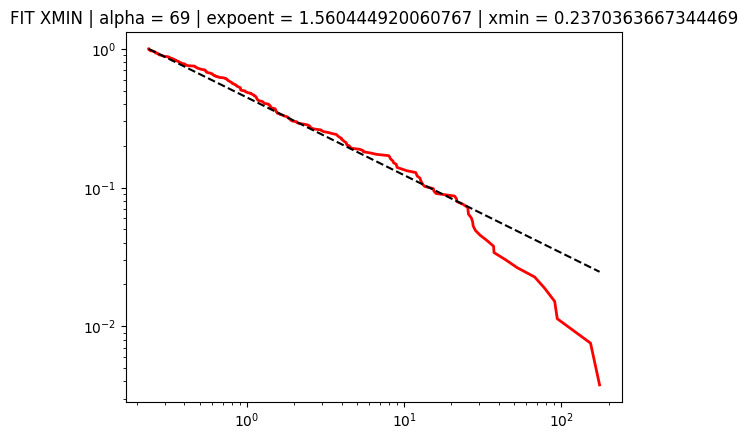

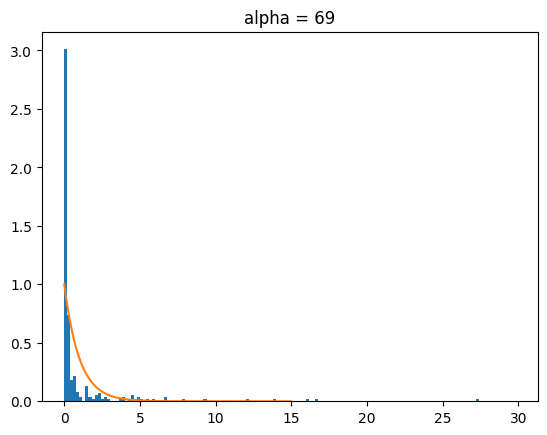


67
POWELAW --- p-value: 0.2926468667924955, PL = True
Calculating best minimal value for power law fit
POWELAW --- p-value: 0.6083540282919664, PL_F = True
LOGNORM --- p-value: 0.0018756333877185788, PL = False
EXP --- p-value: 3.002878313473116e-55, PL = False


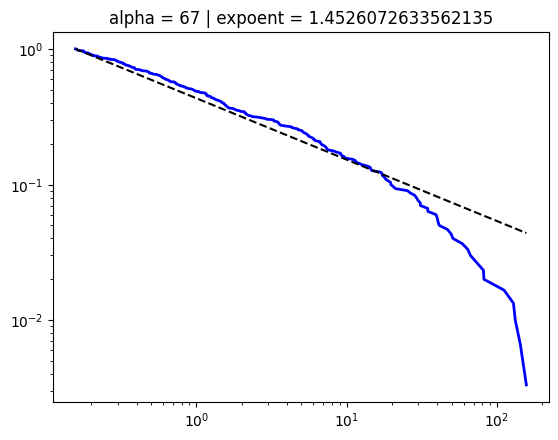

Calculating best minimal value for power law fit


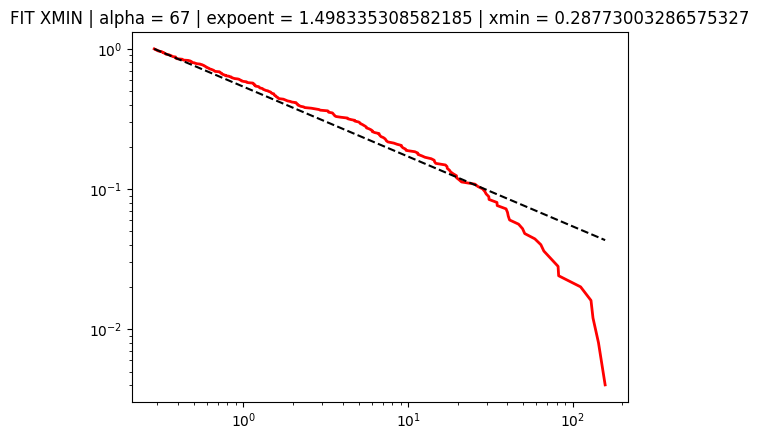

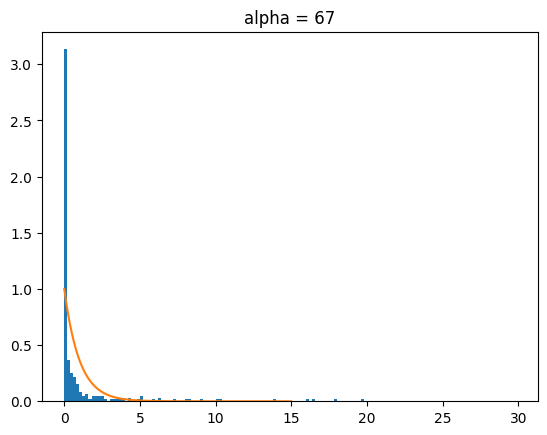


65
POWELAW --- p-value: 0.0031114599011612286, PL = False
Calculating best minimal value for power law fit
POWELAW --- p-value: 0.16422053981533355, PL_F = True
LOGNORM --- p-value: 0.00889130773136791, PL = False
EXP --- p-value: 2.988697837966742e-35, PL = False


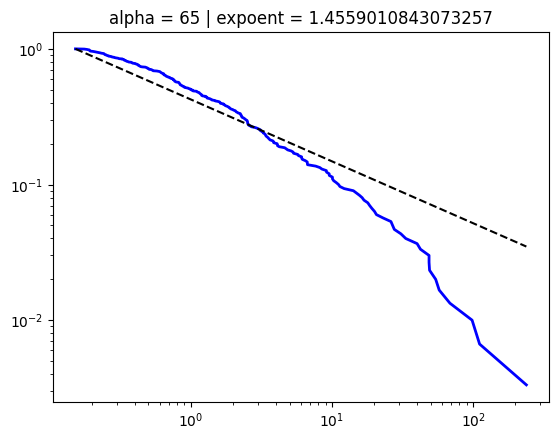

Calculating best minimal value for power law fit


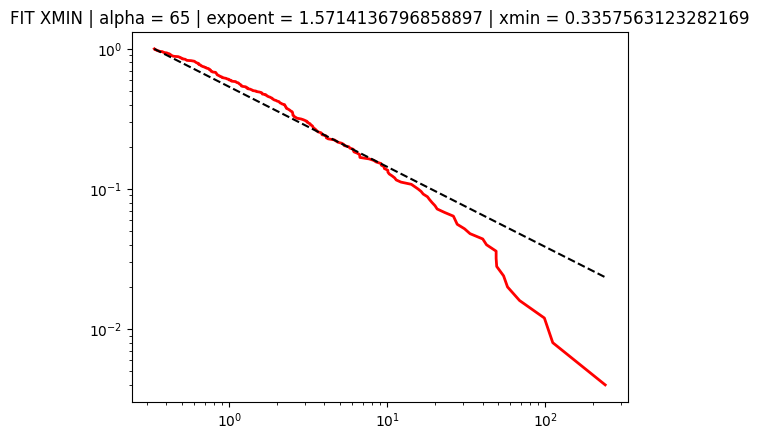

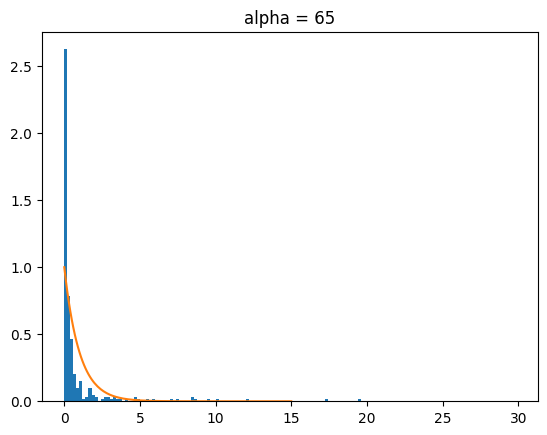


63
POWELAW --- p-value: 0.0009055129810100997, PL = False
Calculating best minimal value for power law fit
POWELAW --- p-value: 0.002197115840324131, PL_F = False
LOGNORM --- p-value: 0.18659374654909533, PL = True
EXP --- p-value: 1.4558851189447226e-26, PL = False


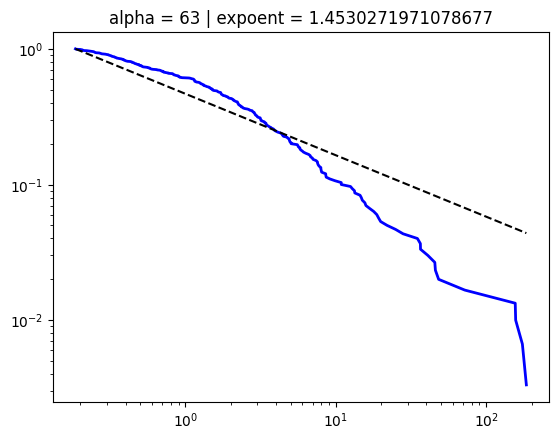

Calculating best minimal value for power law fit


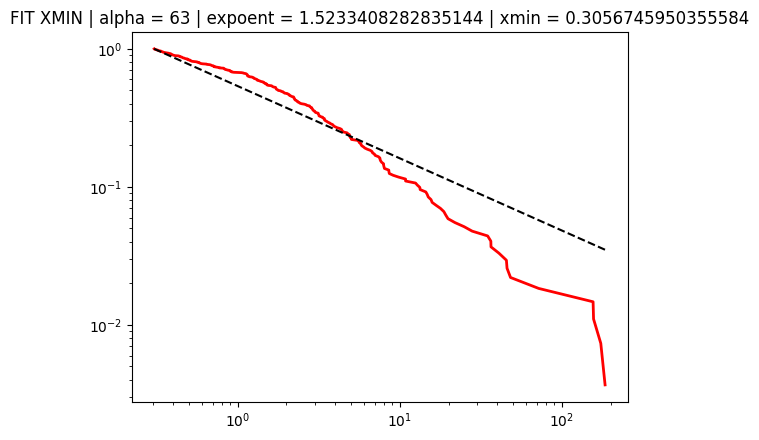

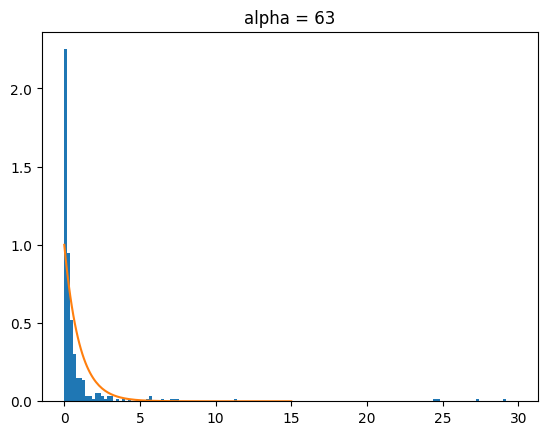


61
POWELAW --- p-value: 0.00023624631733179933, PL = False
Calculating best minimal value for power law fit
POWELAW --- p-value: 0.00028784130029680446, PL_F = False
LOGNORM --- p-value: 0.1873238088840562, PL = True
EXP --- p-value: 1.0549196172237943e-16, PL = False


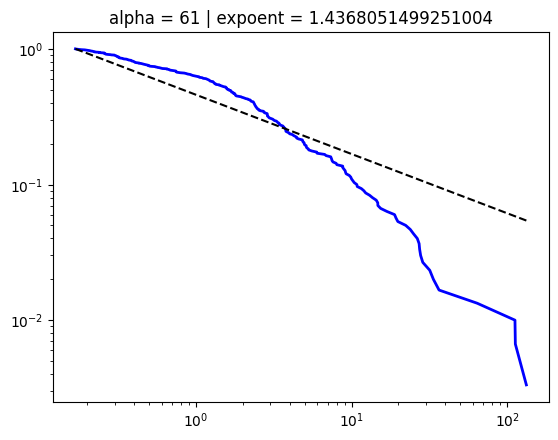

Calculating best minimal value for power law fit


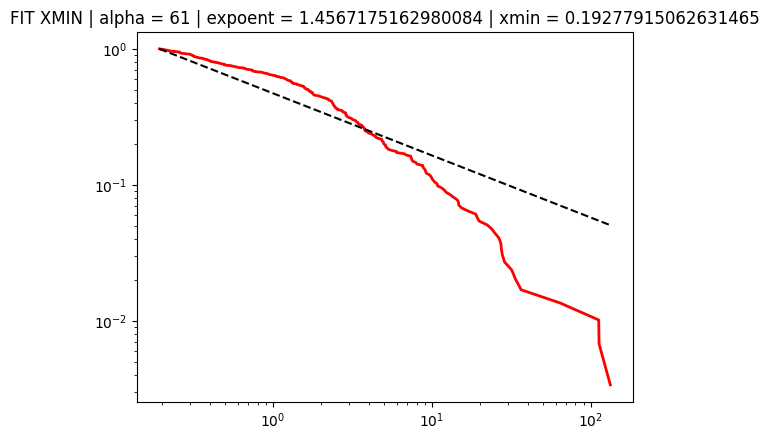

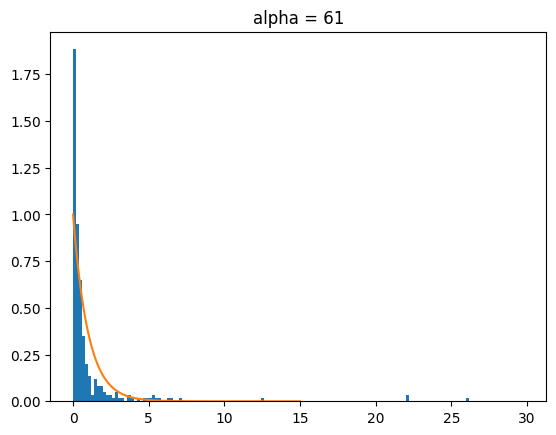


59
POWELAW --- p-value: 2.1664543157120107e-06, PL = False
Calculating best minimal value for power law fit
POWELAW --- p-value: 0.0003311200560277511, PL_F = False
LOGNORM --- p-value: 0.7263129952568781, PL = True
EXP --- p-value: 3.733639148081081e-08, PL = False


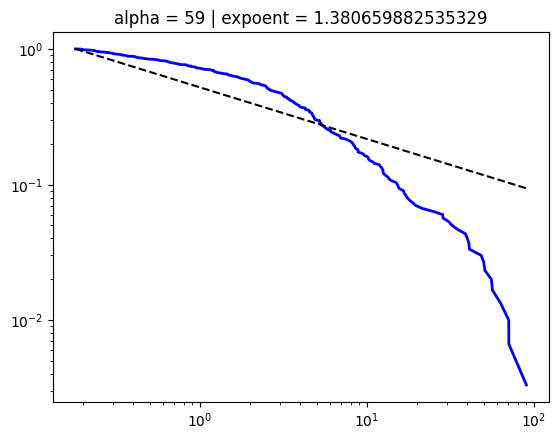

Calculating best minimal value for power law fit


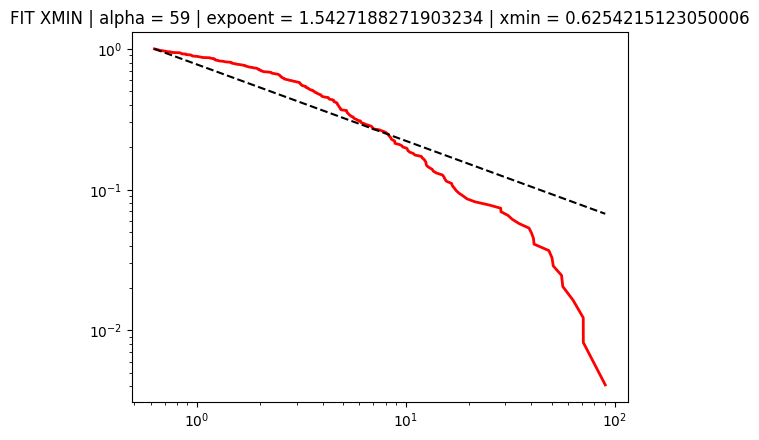

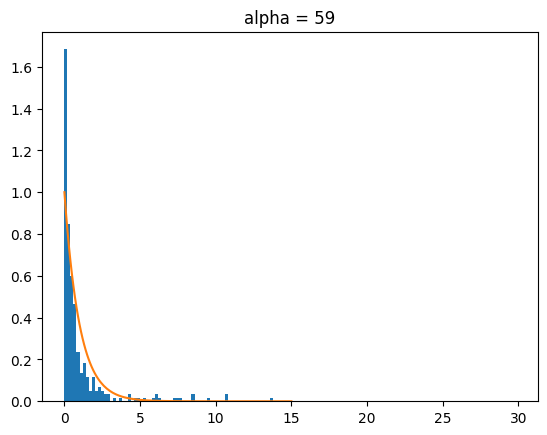


57
POWELAW --- p-value: 1.4252308715018679e-07, PL = False
Calculating best minimal value for power law fit
POWELAW --- p-value: 1.7812178965432715e-05, PL_F = False
LOGNORM --- p-value: 0.1284469811577882, PL = True
EXP --- p-value: 2.2359788720099798e-07, PL = False


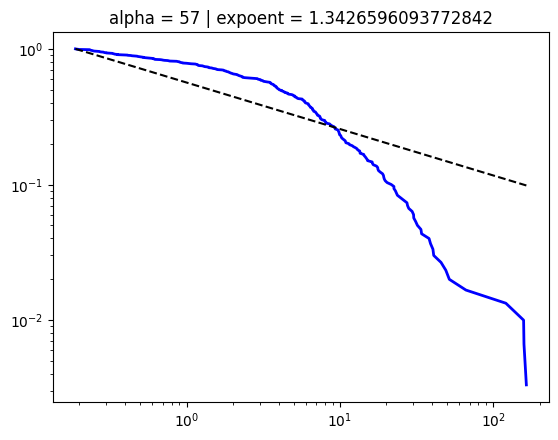

Calculating best minimal value for power law fit


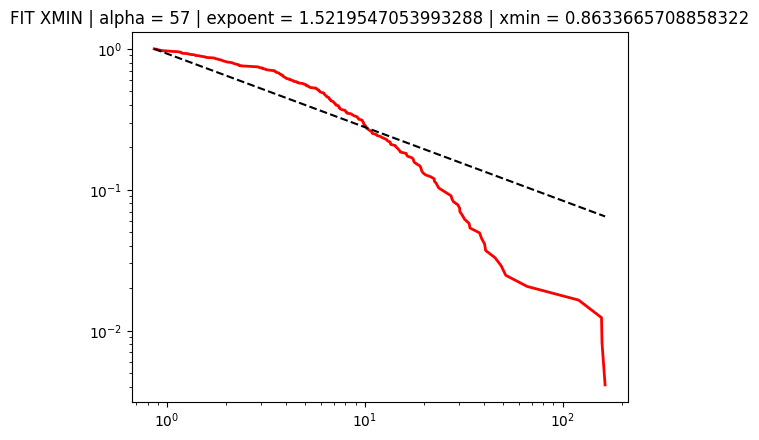

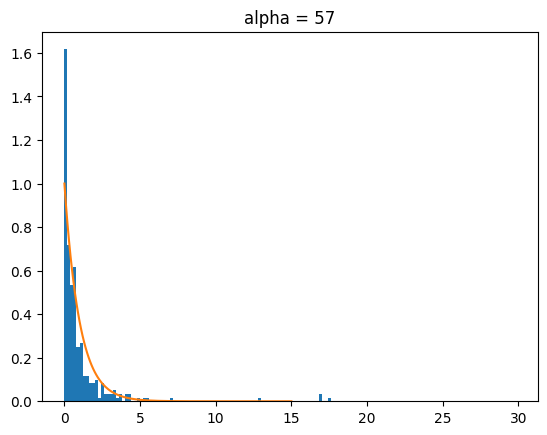


55
POWELAW --- p-value: 3.922502017067572e-13, PL = False
Calculating best minimal value for power law fit
POWELAW --- p-value: 4.06101797522232e-08, PL_F = False
LOGNORM --- p-value: 0.000465952122584041, PL = False
EXP --- p-value: 0.0032079416334089756, PL = False


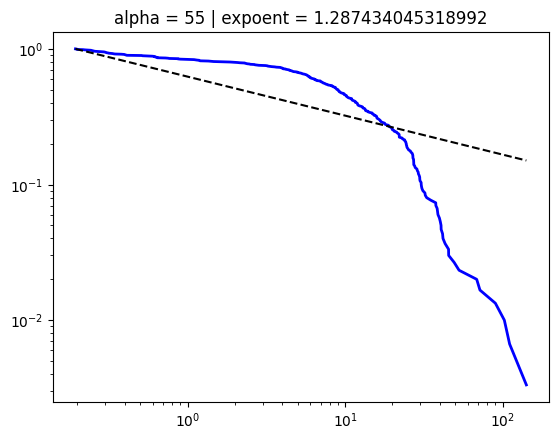

Calculating best minimal value for power law fit


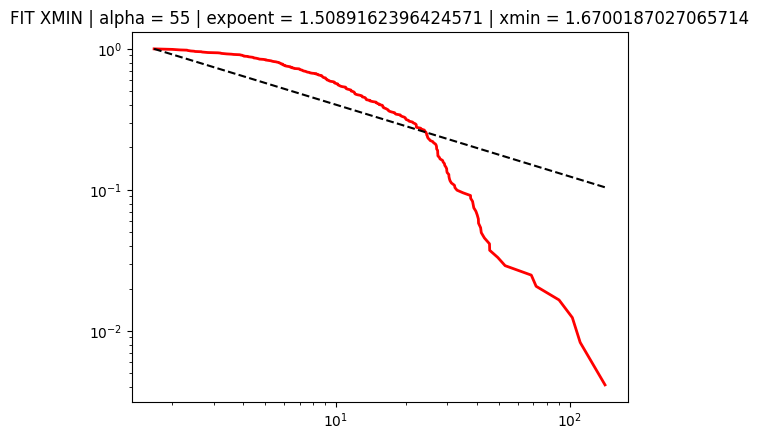

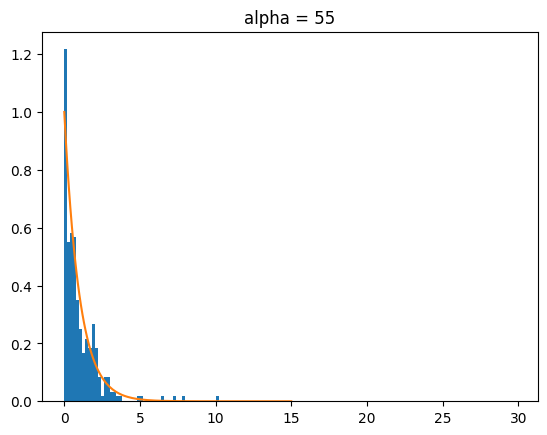


53
POWELAW --- p-value: 3.922502017067572e-13, PL = False
Calculating best minimal value for power law fit
POWELAW --- p-value: 2.3281405981730564e-08, PL_F = False
LOGNORM --- p-value: 7.246867962272254e-05, PL = False
EXP --- p-value: 0.0021442142578137957, PL = False


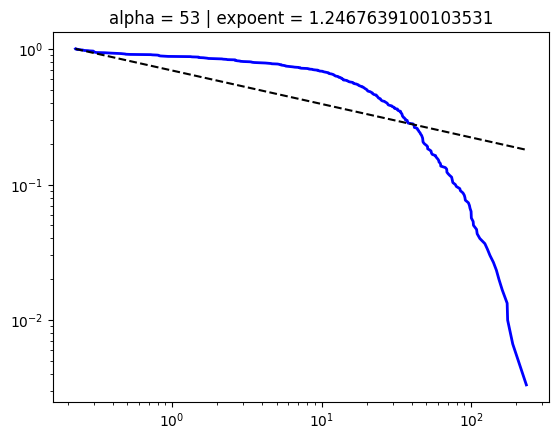

Calculating best minimal value for power law fit


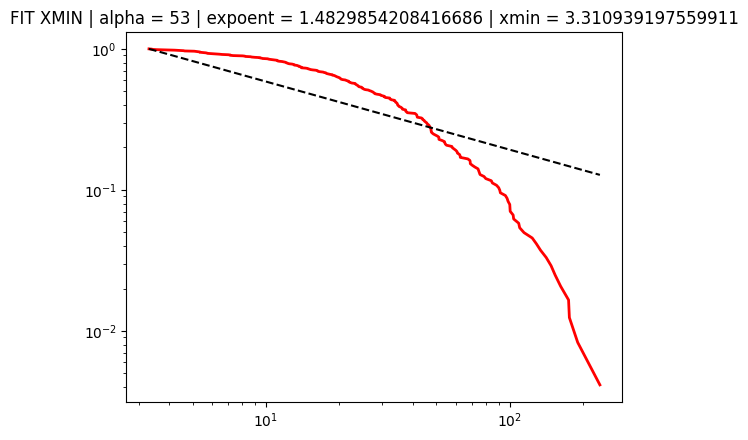

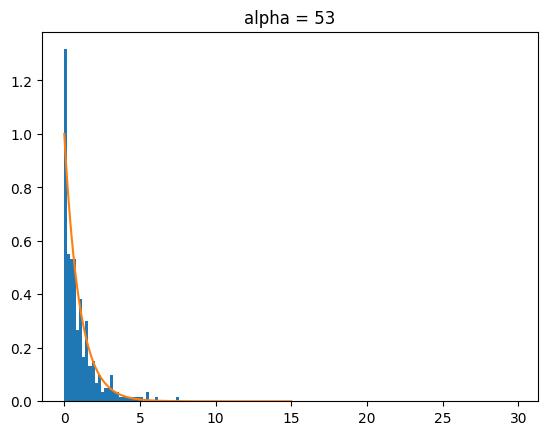


52
POWELAW --- p-value: 2.0608068972918464e-13, PL = False
Calculating best minimal value for power law fit
POWELAW --- p-value: 2.500282470386631e-07, PL_F = False
LOGNORM --- p-value: 0.0002091591548595492, PL = False
EXP --- p-value: 0.0005280981524123159, PL = False


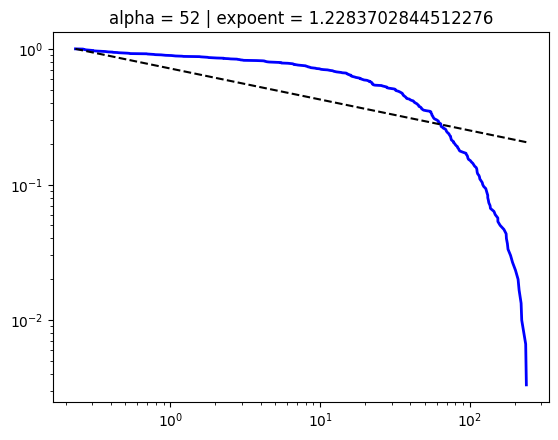

Calculating best minimal value for power law fit


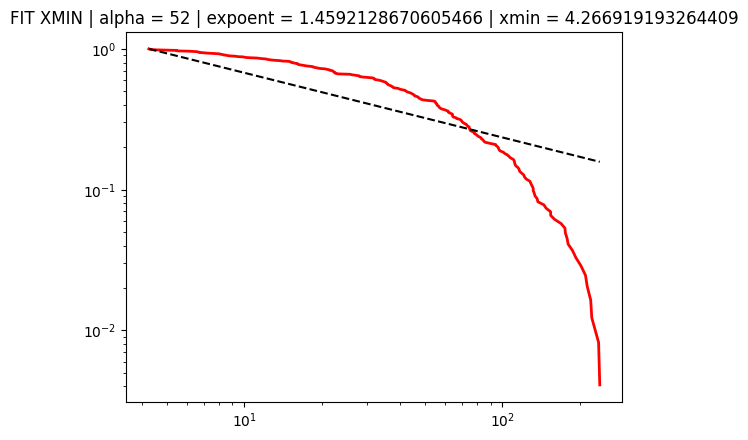

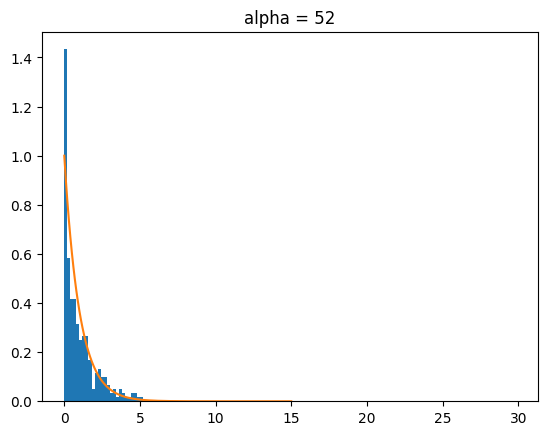


51
POWELAW --- p-value: 4.499933086722873e-16, PL = False
Calculating best minimal value for power law fit
POWELAW --- p-value: 8.71063762632476e-08, PL_F = False
LOGNORM --- p-value: 1.9129176874983487e-05, PL = False
EXP --- p-value: 0.004887862422984248, PL = False


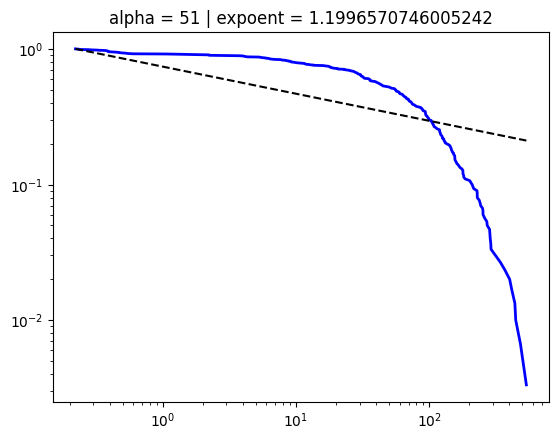

Calculating best minimal value for power law fit


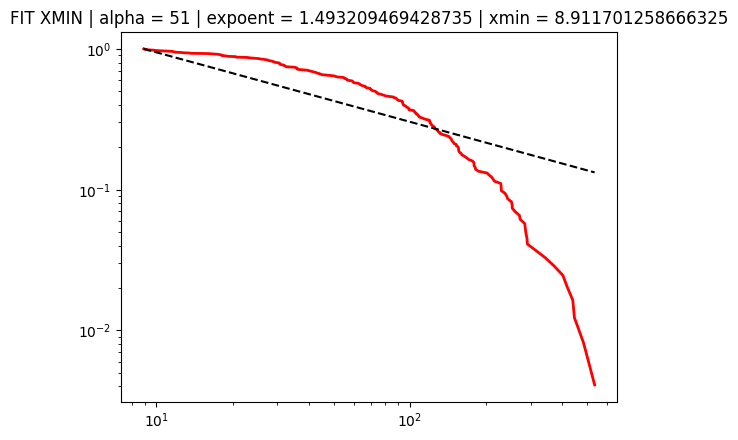

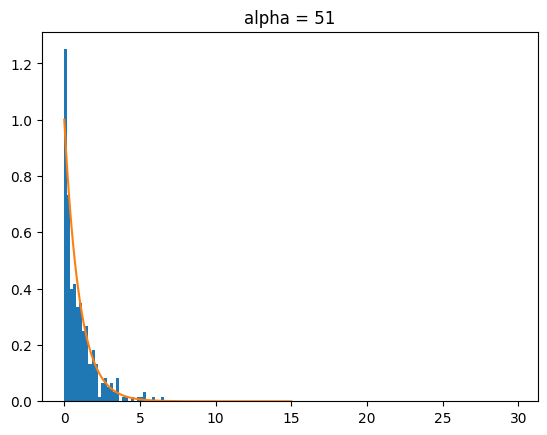


50
POWELAW --- p-value: 1.150018983956209e-17, PL = False
Calculating best minimal value for power law fit
POWELAW --- p-value: 7.020742940214858e-08, PL_F = False
LOGNORM --- p-value: 2.6784845527815303e-07, PL = False
EXP --- p-value: 0.0048221272630348455, PL = False


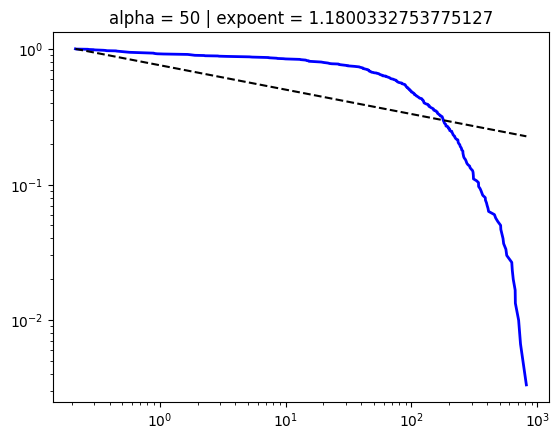

Calculating best minimal value for power law fit


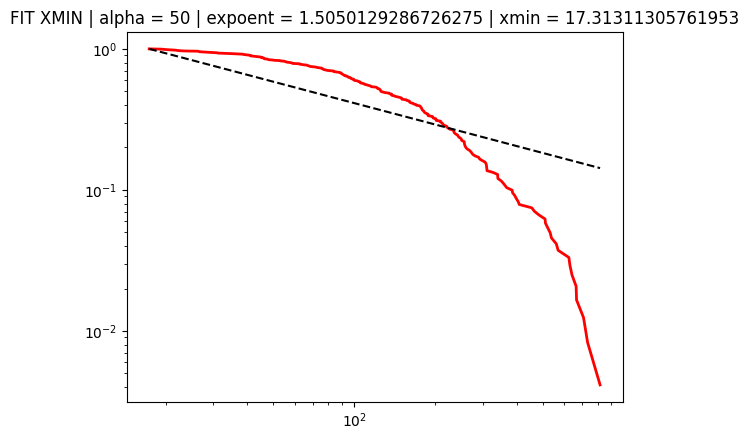

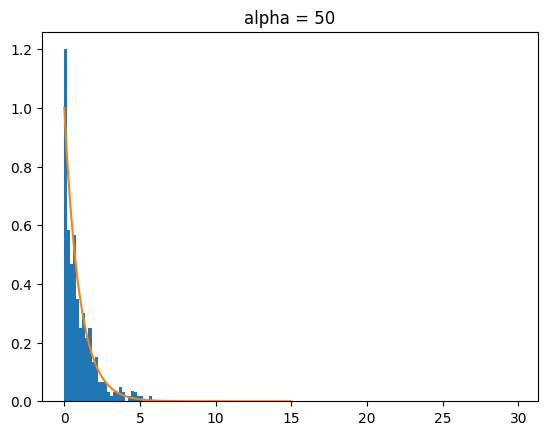


49
POWELAW --- p-value: 7.903952866429726e-22, PL = False
Calculating best minimal value for power law fit
POWELAW --- p-value: 9.361040562396327e-05, PL_F = False
LOGNORM --- p-value: 6.260960498659935e-06, PL = False
EXP --- p-value: 0.07135961590229978, PL = True


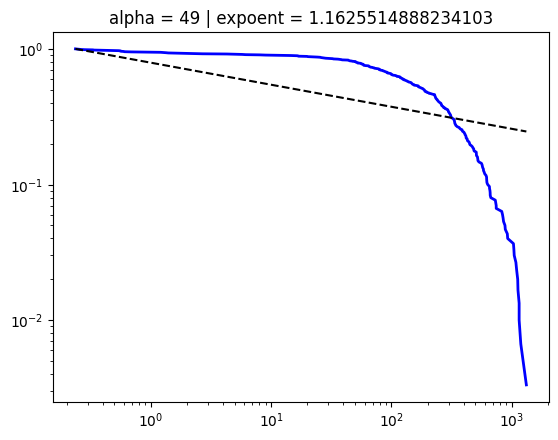

Calculating best minimal value for power law fit


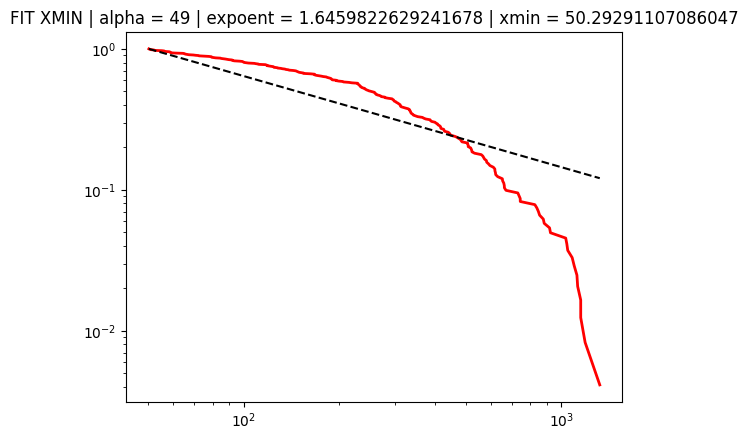

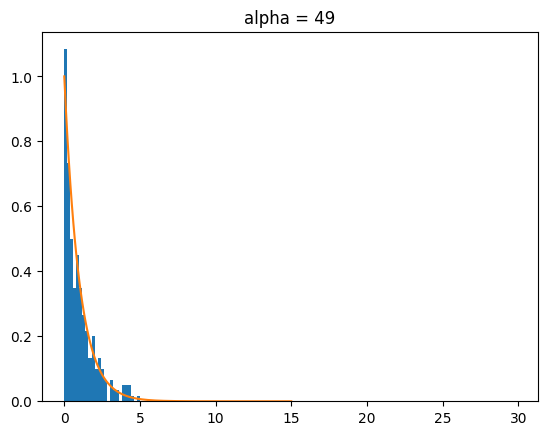

In [40]:
# test_durations(results_U100,True)
test_durations(results_U1000,True)


71
POWELAW --- p-value: 7.966459467068371e-14, PL = False
Calculating best minimal value for power law fit
POWELAW --- p-value: 1.3274570272814805e-09, PL_F = False
LOGNORM --- p-value: 0.0017769463715472907, LN = False
EXP --- p-value: 4.695568559483677e-33, EXP = False


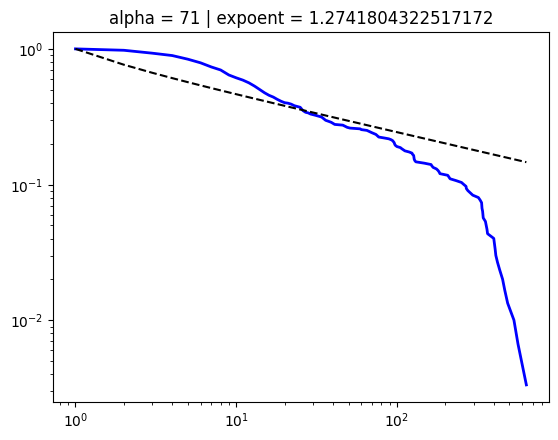

Calculating best minimal value for power law fit


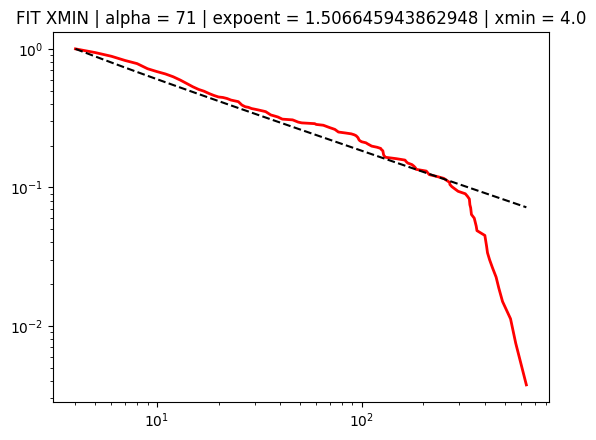

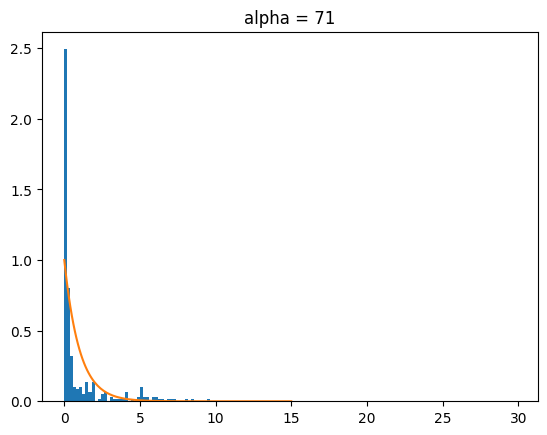


69
POWELAW --- p-value: 7.209074883732408e-10, PL = False
Calculating best minimal value for power law fit
POWELAW --- p-value: 1.6501857404265815e-05, PL_F = False
LOGNORM --- p-value: 0.013058580800053836, LN = False
EXP --- p-value: 6.618318672599766e-32, EXP = False


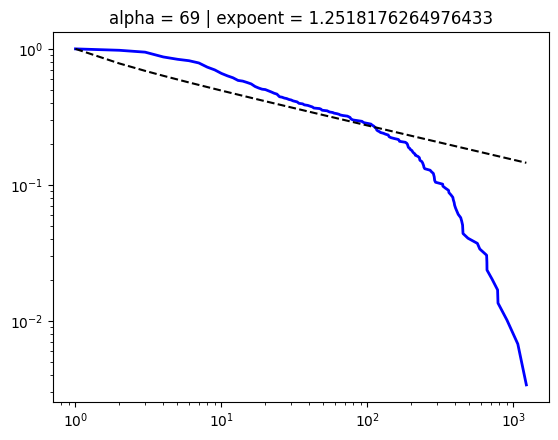

Calculating best minimal value for power law fit


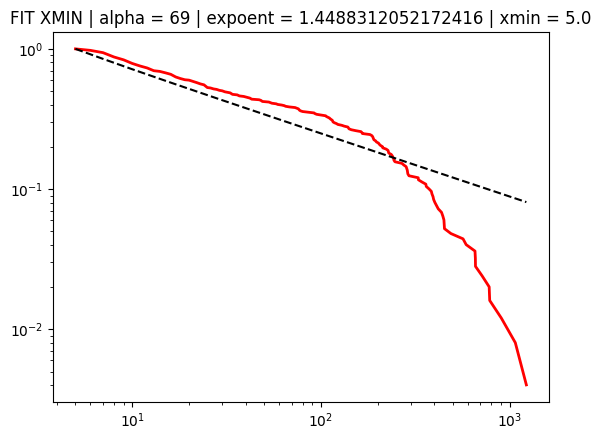

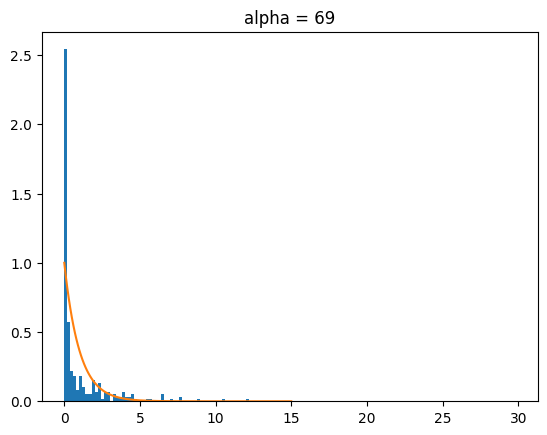


67
POWELAW --- p-value: 7.053954822115187e-10, PL = False
Calculating best minimal value for power law fit
POWELAW --- p-value: 4.8142259795161485e-11, PL_F = False
LOGNORM --- p-value: 1.4782557315667552e-05, LN = False
EXP --- p-value: 5.362463806273291e-43, EXP = False


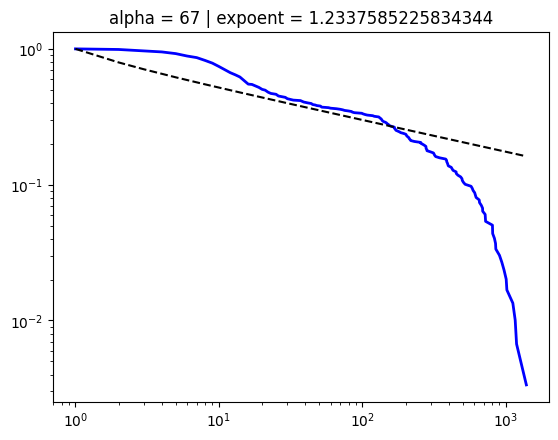

Calculating best minimal value for power law fit


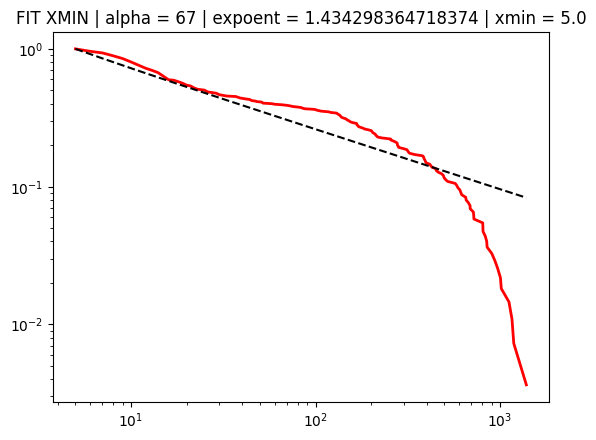

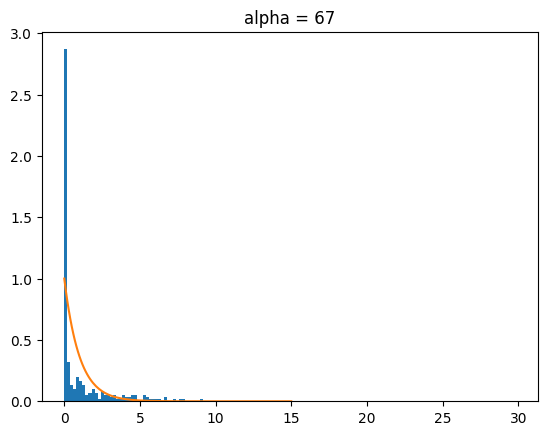


65
POWELAW --- p-value: 5.257297974787816e-10, PL = False
Calculating best minimal value for power law fit
POWELAW --- p-value: 9.642855387354007e-07, PL_F = False
LOGNORM --- p-value: 0.0003344440869694312, LN = False
EXP --- p-value: 1.5422091688651526e-43, EXP = False


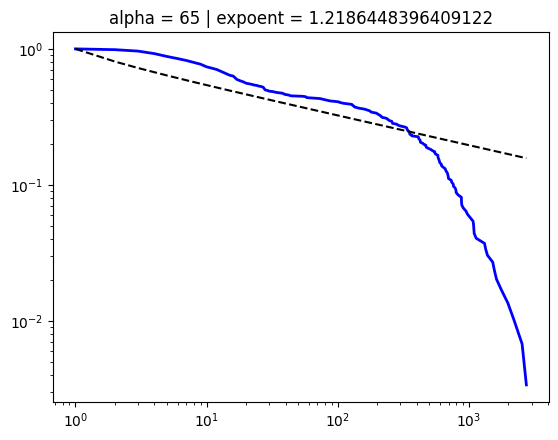

Calculating best minimal value for power law fit


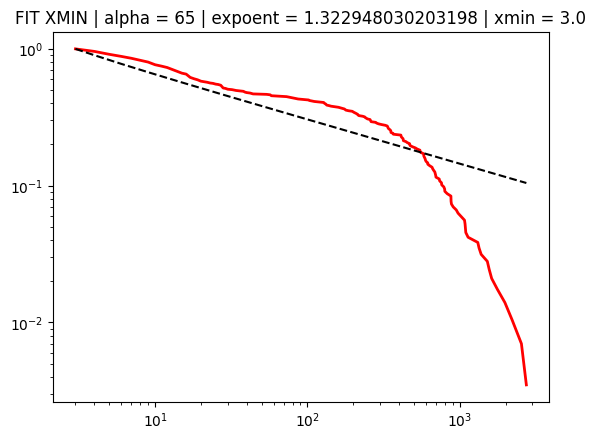

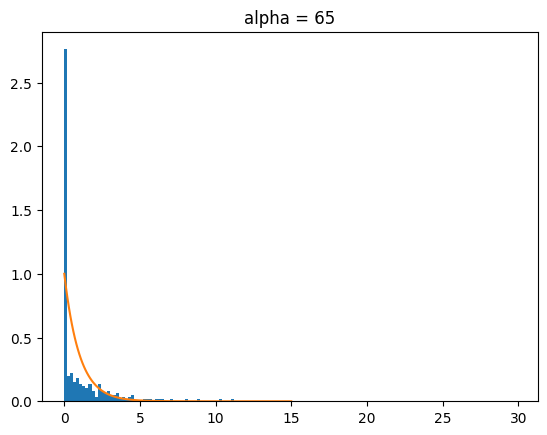


63
POWELAW --- p-value: 2.3334767505171937e-08, PL = False
Calculating best minimal value for power law fit
POWELAW --- p-value: 4.140549018649573e-08, PL_F = False
LOGNORM --- p-value: 2.3159258064164513e-05, LN = False
EXP --- p-value: 3.608551096504402e-51, EXP = False


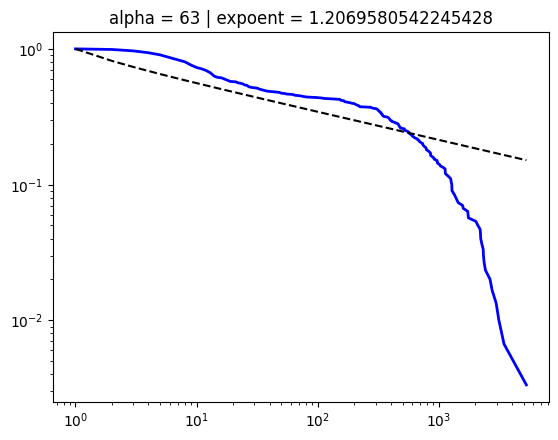

Calculating best minimal value for power law fit


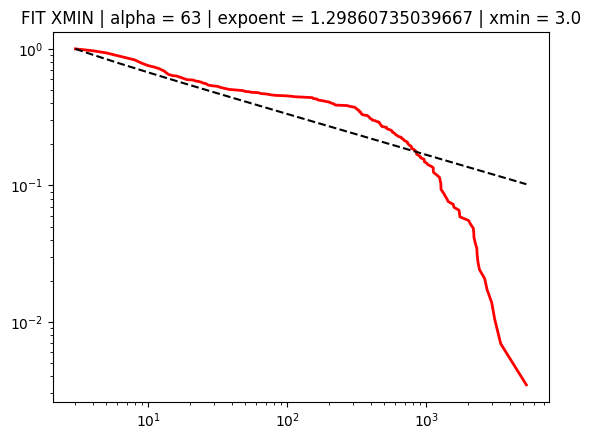

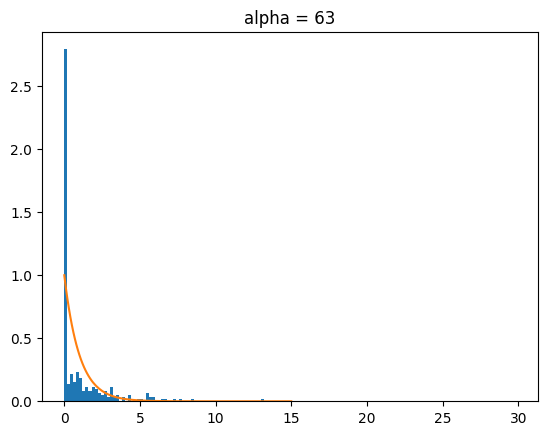


61
POWELAW --- p-value: 9.086618481258244e-09, PL = False
Calculating best minimal value for power law fit
POWELAW --- p-value: 2.3494625397267618e-06, PL_F = False
LOGNORM --- p-value: 6.262414254826563e-06, LN = False
EXP --- p-value: 9.912202157020589e-37, EXP = False


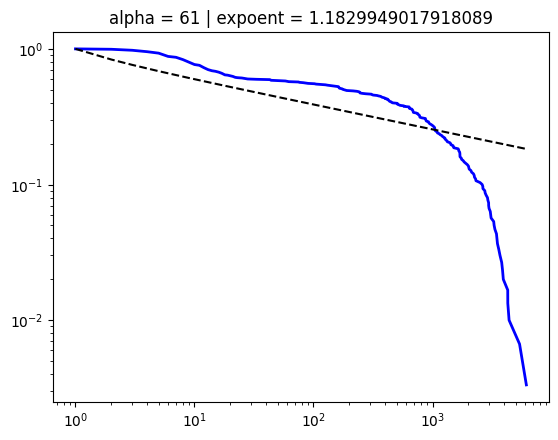

Calculating best minimal value for power law fit


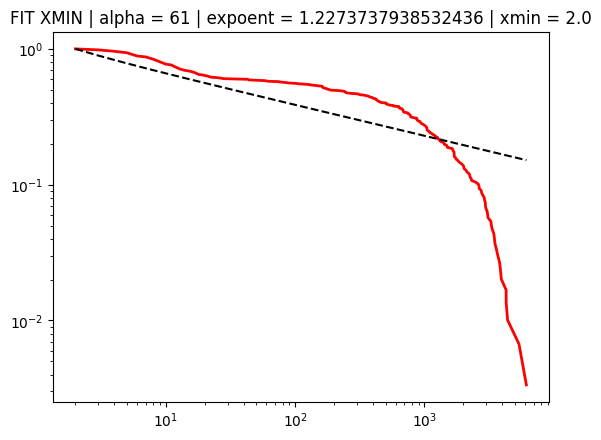

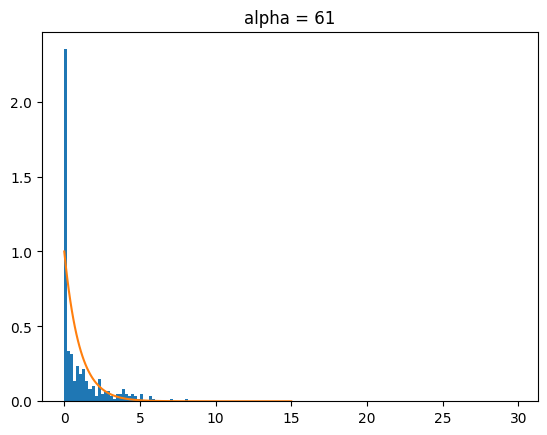


59
POWELAW --- p-value: 1.7387525498213273e-08, PL = False
Calculating best minimal value for power law fit
POWELAW --- p-value: 2.0113848767365355e-06, PL_F = False
LOGNORM --- p-value: 2.9531627231700926e-06, LN = False
EXP --- p-value: 3.934757765456123e-31, EXP = False


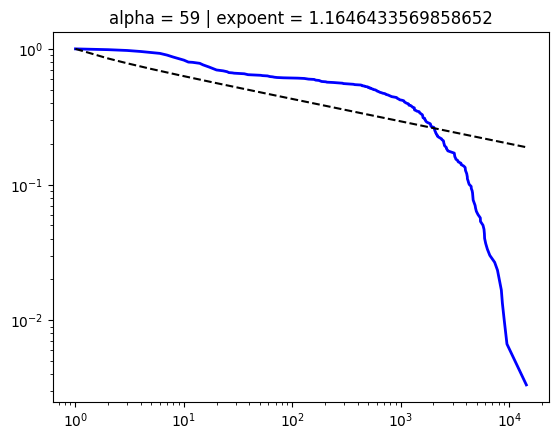

Calculating best minimal value for power law fit


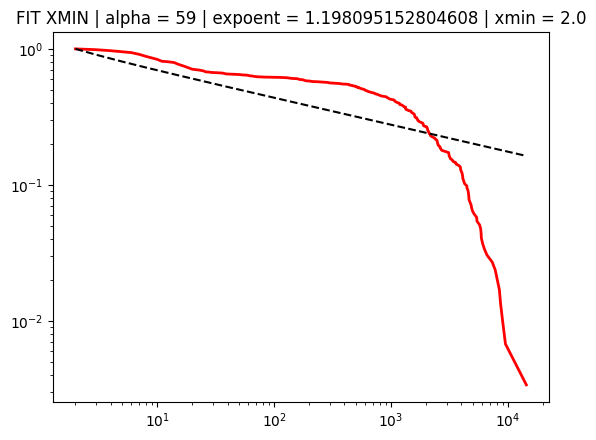

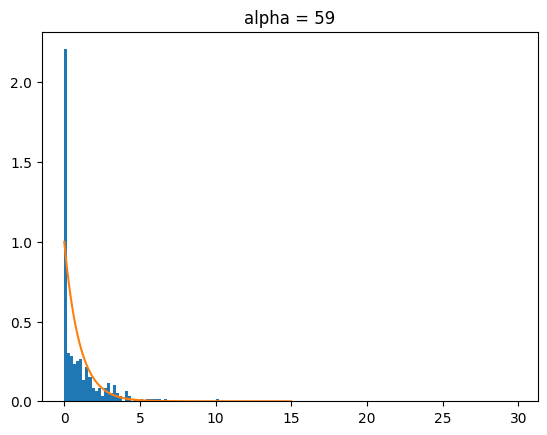


57
POWELAW --- p-value: 1.646651408926896e-08, PL = False
Calculating best minimal value for power law fit
POWELAW --- p-value: 1.646651408926896e-08, PL_F = False
LOGNORM --- p-value: 1.8300107059830734e-08, LN = False
EXP --- p-value: 2.2000718733072653e-23, EXP = False


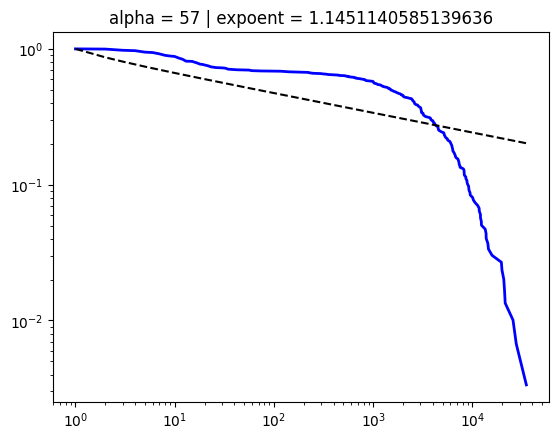

Calculating best minimal value for power law fit


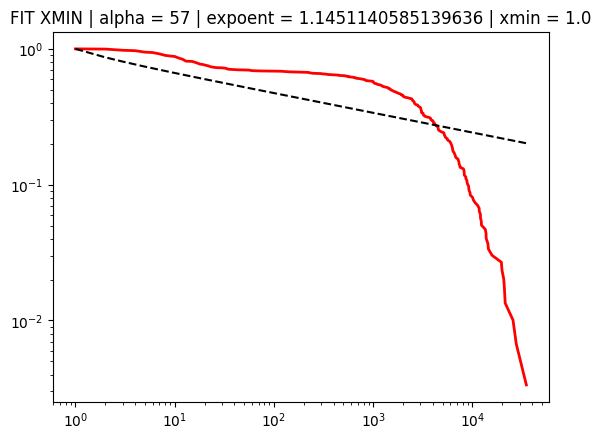

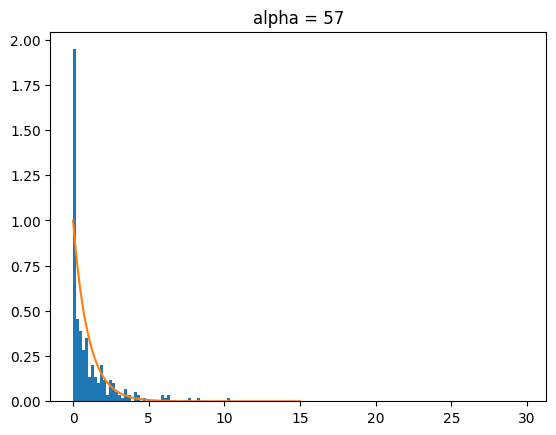


55
POWELAW --- p-value: 9.761074974795628e-10, PL = False
Calculating best minimal value for power law fit
POWELAW --- p-value: 9.761074974795628e-10, PL_F = False
LOGNORM --- p-value: 2.999264028142306e-13, LN = False
EXP --- p-value: 8.530809109375716e-17, EXP = False


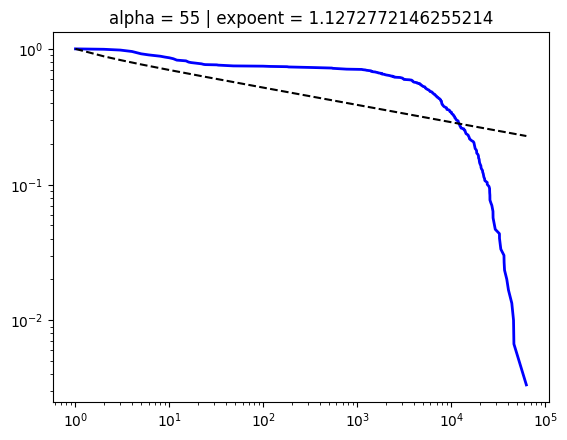

Calculating best minimal value for power law fit


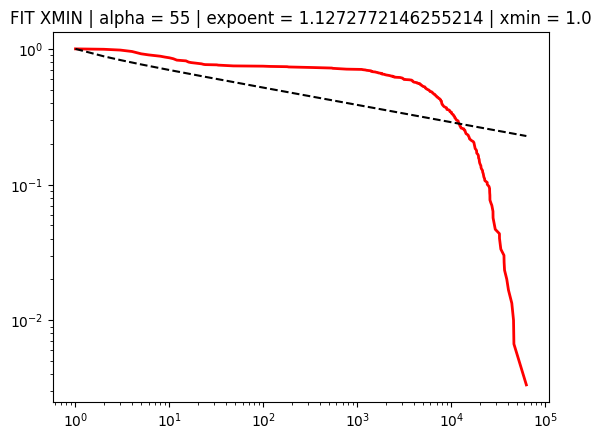

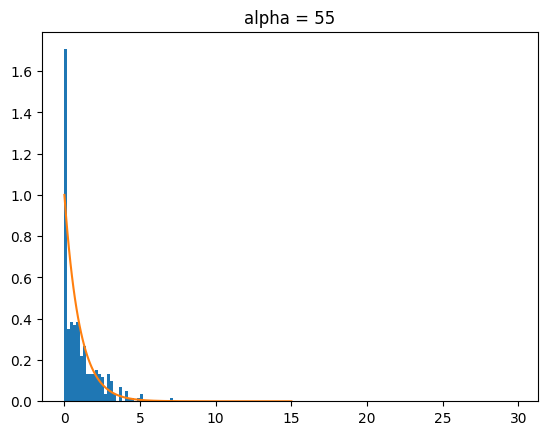


53
POWELAW --- p-value: 1.6742220560721307e-09, PL = False
Calculating best minimal value for power law fit
POWELAW --- p-value: 1.6742220560721307e-09, PL_F = False
LOGNORM --- p-value: 3.772670720953363e-14, LN = False
EXP --- p-value: 2.4063418241550364e-13, EXP = False


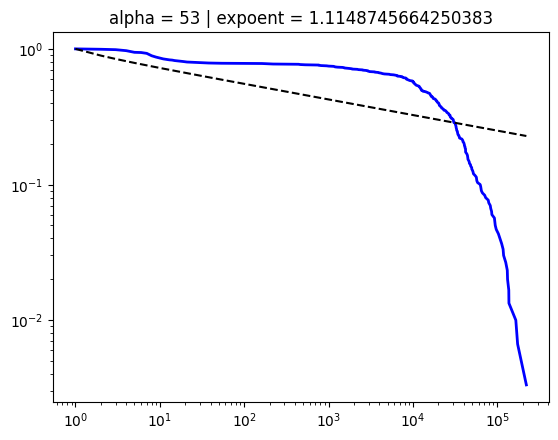

Calculating best minimal value for power law fit


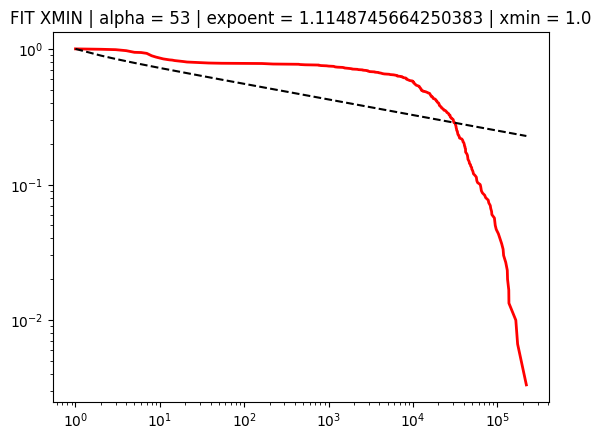

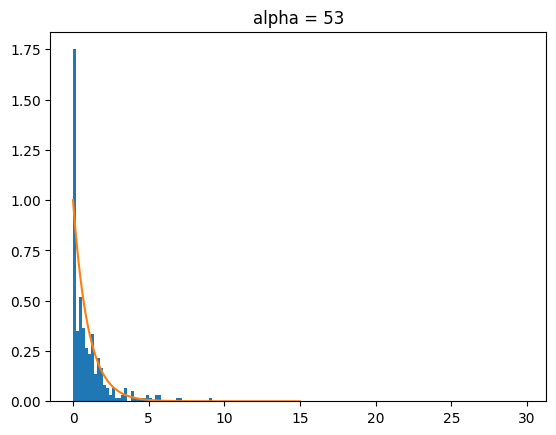


52
POWELAW --- p-value: 1.1084920329184845e-12, PL = False
Calculating best minimal value for power law fit
POWELAW --- p-value: 4.185403320854917e-12, PL_F = False
LOGNORM --- p-value: 1.6238931935044001e-13, LN = False
EXP --- p-value: 5.865189694050272e-10, EXP = False


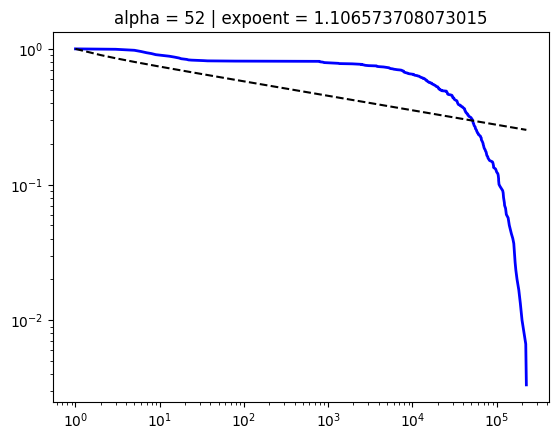

Calculating best minimal value for power law fit


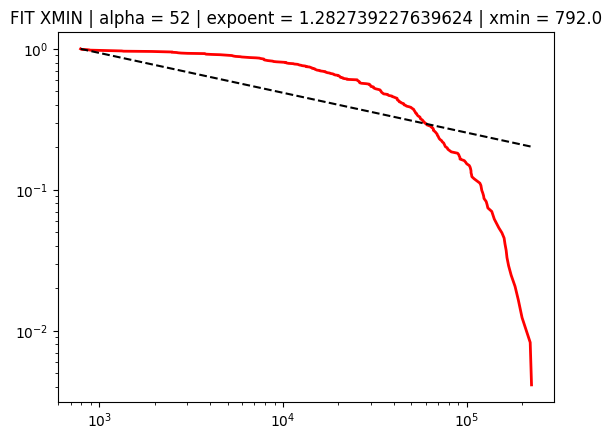

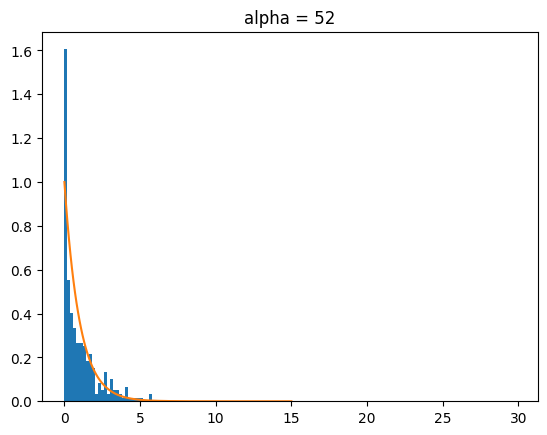


51
POWELAW --- p-value: 3.164435823795004e-17, PL = False
Calculating best minimal value for power law fit
POWELAW --- p-value: 6.232794808130045e-10, PL_F = False
LOGNORM --- p-value: 4.4286423115559434e-17, LN = False
EXP --- p-value: 3.5095417501785896e-07, EXP = False


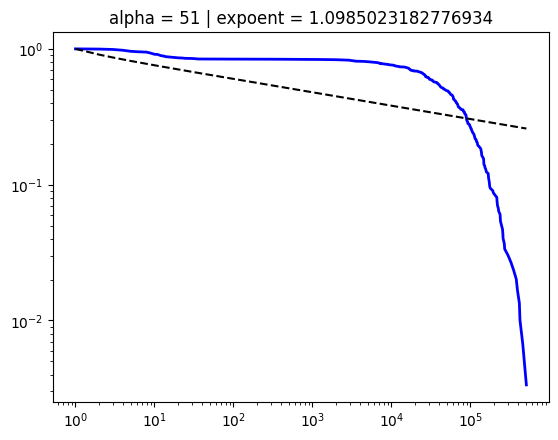

Calculating best minimal value for power law fit


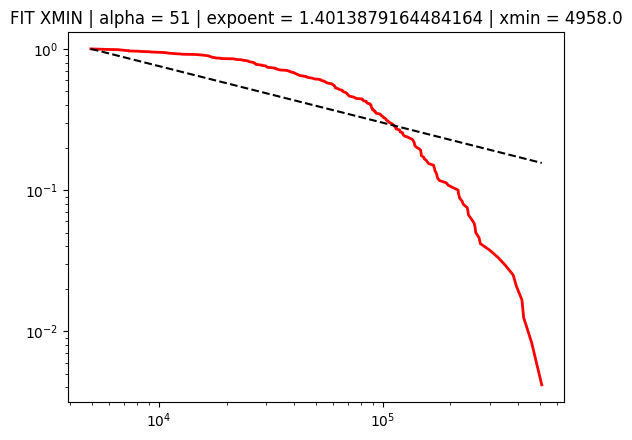

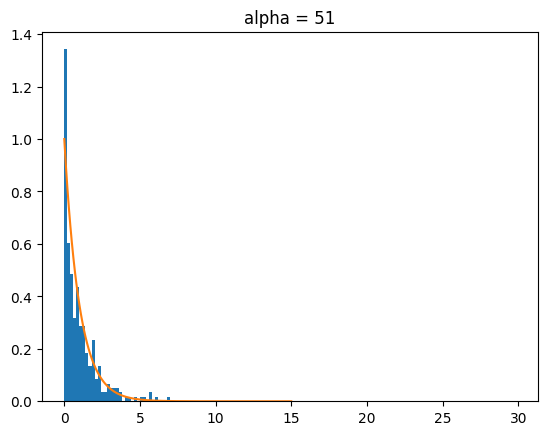


50
POWELAW --- p-value: 1.2912690022800936e-19, PL = False
Calculating best minimal value for power law fit
POWELAW --- p-value: 1.2904487776999007e-07, PL_F = False
LOGNORM --- p-value: 4.2211033576652905e-17, LN = False
EXP --- p-value: 6.694377367733666e-06, EXP = False


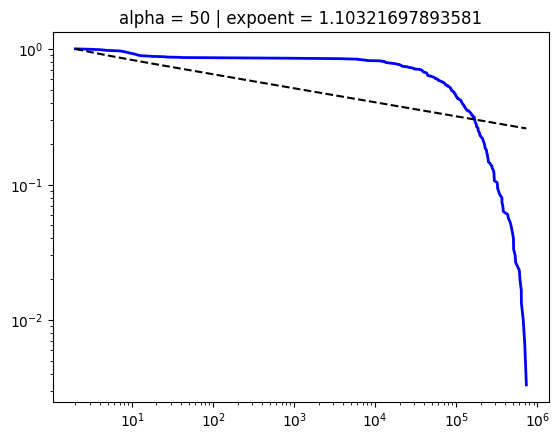

Calculating best minimal value for power law fit


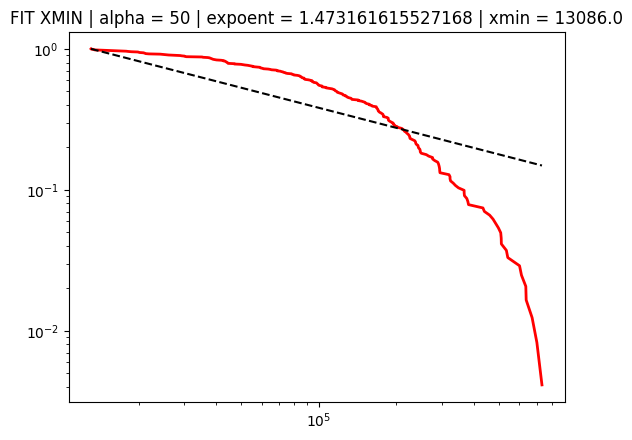

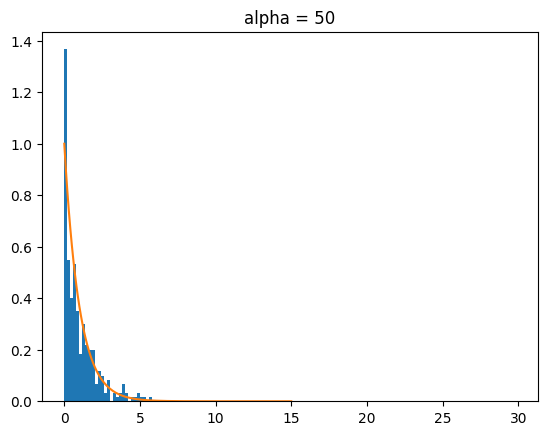


49
POWELAW --- p-value: 2.017756889591471e-24, PL = False
Calculating best minimal value for power law fit
POWELAW --- p-value: 1.6964841826549725e-05, PL_F = False
LOGNORM --- p-value: 2.9646083723445694e-18, LN = False
EXP --- p-value: 0.003471508454558289, EXP = False


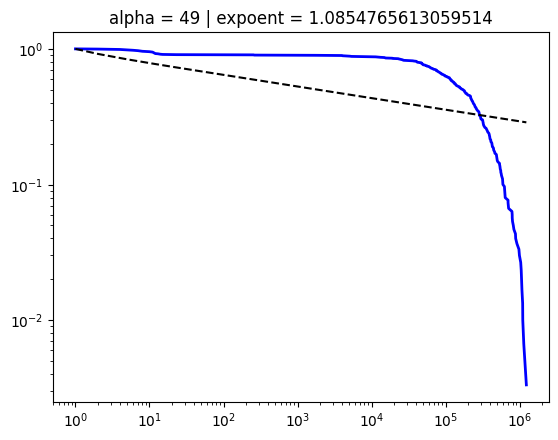

Calculating best minimal value for power law fit


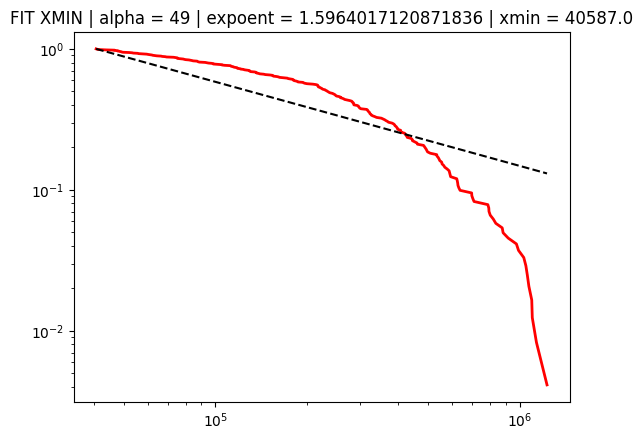

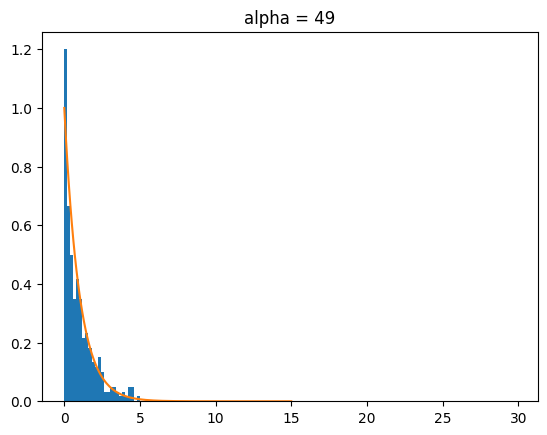

In [41]:
# test_sizes(results_U100, True)
test_sizes(results_U1000, True)

In [43]:
# np.sort(results_U1000[50.0][1])

In [37]:
# for xmin in range(1,30):
    # print()
    # print(xmin)
    # sizes = [item for item in results_U100[6.0][1] if item>xmin]
    # print(test_exp(sizes))
    # print(test_lognorm(sizes))

In [29]:
# pd.Series(np.sort(results_U100[6.0][1])).hist()
# sizes = results_U100[6.0][1]
# plt.hist(np.array(sizes)/np.mean(sizes), bins=[item/5 for item in range(15*10)], density=True)
# plt.title(f'alpha = {keyy}')
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
# plt.show()

In [ ]:
# results_U100.keys()

dict_keys([np.float64(6.1), np.float64(6.0), np.float64(5.9), np.float64(5.8), np.float64(5.7), np.float64(5.6), np.float64(5.5), np.float64(5.4), np.float64(5.3), np.float64(5.2), np.float64(5.1), np.float64(5.0), np.float64(4.9), np.float64(4.8), np.float64(4.7)])